# Data Analytics for Health - Task 1.1: Exploratory Data Analysis

## Overview
This notebook performs exploratory data analysis (EDA) on four healthcare datasets:
1. **Heart Diagnoses** - Clinical notes and patient information
2. **Laboratory Events Codes** - Lab test results and measurements  
3. **Microbiology Events Codes** - Microbiology test results
4. **Procedure Codes** - Medical procedures and ICD codes

## Objectives
- Load and examine the structure of all four datasets
- Perform data understanding and quality assessment
- Create meaningful distribution plots for key variables
- Identify patterns and characteristics in the healthcare data

---

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Set up file paths
notebook_dir = Path.cwd().resolve()
data_path = (notebook_dir / '..' / '..' / 'Data').resolve()
out_dir = (notebook_dir / '..' / 'plots').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Data path: {data_path}")
print(f"Output directory: {out_dir}")

Libraries imported successfully
Data path: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data
Output directory: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\data_analytics_4_health_unipi\plots


## 1. Data Loading

We'll load all four datasets and examine their basic structure to understand what we're working with.


In [11]:
# Load all four datasets
datasets = {
    "Heart Diagnoses": "heart_diagnoses_1.csv",
    "Laboratory Events": "laboratory_events_codes_2.csv", 
    "Microbiology Events": "microbiology_events_codes_3.csv",
    "Procedure Codes": "procedure_code_4.csv"
}

# Load datasets into DataFrames
dfs = {}
for name, filename in datasets.items():
    filepath = data_path / filename
    dfs[name] = pd.read_csv(filepath)
    print(f"Loaded {name}: {dfs[name].shape[0]:,} rows × {dfs[name].shape[1]} columns")

# Assign to individual variables for convenience
df1 = dfs["Heart Diagnoses"]  # heart_diagnoses
df2 = dfs["Laboratory Events"]  # laboratory_events
df3 = dfs["Microbiology Events"]  # microbiology_events  
df4 = dfs["Procedure Codes"]  # procedure_codes

print(f"\nAll datasets loaded successfully!")


Loaded Heart Diagnoses: 4,864 rows × 25 columns
Loaded Laboratory Events: 978,503 rows × 14 columns
Loaded Microbiology Events: 15,587 rows × 14 columns
Loaded Procedure Codes: 14,497 rows × 6 columns

All datasets loaded successfully!


## 2. Data Understanding

Let's examine the structure, data types, and basic characteristics of each dataset to understand what we're working with.


In [28]:
# Feature-wise describe() for all datasets
print("Generating per-feature describe() for all datasets...")
print("="*80)

for dataset_name, df in dfs.items():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"Rows: {len(df):,}, Columns: {df.shape[1]}")
    print(f"{'='*80}")
    
    print(df.describe())

print("\nAll feature-wise describe() summaries completed.")

Generating per-feature describe() for all datasets...

DATASET: Heart Diagnoses
Rows: 4,864, Columns: 25
         subject_id       hadm_id     note_seq  subject_id_dx          age  \
count  4.864000e+03  4.864000e+03  4864.000000   4.864000e+03  1363.000000   
mean   1.510717e+07  2.501745e+07    14.690995   1.500158e+07    68.978723   
std    2.938761e+06  2.873736e+06     8.260520   2.879841e+06    14.973358   
min    1.000098e+07  2.000446e+07     2.000000   1.000098e+07    18.000000   
25%    1.252385e+07  2.260252e+07     9.000000   1.246683e+07    60.000000   
50%    1.507553e+07  2.503238e+07    14.000000   1.498641e+07    70.000000   
75%    1.764939e+07  2.746833e+07    19.000000   1.750476e+07    81.000000   
max    1.999860e+07  2.999967e+07    94.000000   1.999850e+07    95.000000   

       anchor_year  
count  1363.000000  
mean   2155.620690  
std      23.400097  
min    2110.000000  
25%    2136.000000  
50%    2157.000000  
75%    2174.000000  
max    2206.000000  

DA

In [97]:
for dataset_name, df in dfs.items():
    print(f"\n{'='*80}")
    print(f"DATASET: {dataset_name}")
    print(f"Rows: {len(df):,}, Columns: {df.shape[1]}")
    if "hadm_id" in df.columns:
        print(f"unique hadm_id: {df["hadm_id"].nunique()}")
    if "subject_id" in df.columns:
        print(f"unique subjectids: {df["subject_id"].nunique()}")
        print("Num of subjectids with NaN hadm", df[df['hadm_id'].isna()]['subject_id'].nunique())
        # check
        print(df.groupby('subject_id')['hadm_id'].nunique().value_counts().head())
        print("TEST 1 HADMID -> 1 subject1d, should be 1!: ", df.groupby('hadm_id')['subject_id'].nunique().max())
        # verify
        print(df[df.duplicated(subset=['hadm_id', 'subject_id'], keep=False)][['hadm_id','subject_id']].drop_duplicates().sort_values('hadm_id'))
        print(df.groupby('hadm_id')['subject_id'].nunique().value_counts())
    print(f"{'='*80}")


DATASET: Heart Diagnoses
Rows: 4,864, Columns: 25
unique hadm_id: 4761
unique subjectids: 4392
Num of subjectids with NaN hadm 0
hadm_id
1    4001
2     324
3      56
4       8
5       3
Name: count, dtype: int64
TEST 1 HADMID -> 1 subject1d, should be 1!:  3
Empty DataFrame
Columns: [hadm_id, subject_id]
Index: []
subject_id
1    4660
2      99
3       2
Name: count, dtype: int64

DATASET: Laboratory Events
Rows: 978,503, Columns: 18
unique hadm_id: 4752

DATASET: Microbiology Events
Rows: 15,587, Columns: 15
unique hadm_id: 2454
unique subjectids: 2616
Num of subjectids with NaN hadm 0
hadm_id
1    2488
2     116
3      12
Name: count, dtype: int64
TEST 1 HADMID -> 1 subject1d, should be 1!:  5
          hadm_id  subject_id
5530   20007905.0    13709807
9173   20013602.0    16110697
13886  20015883.0    19151721
2649   20026345.0    11968906
6799   20029361.0    14586198
...           ...         ...
7516   29957999.0    15026237
646    29961953.0    10525376
10344  29969310.0    16

EACH HADM_ID HSOULD MAP TO EXACTLY ONE SUBJECTID 1-1. (1 subject id can have multiple admissions though,)
- But this is not the case for df1, df3 !! (df2 deosnt have subjectid, df4 passes test == 1)
- so what to do??

In [8]:
df = df1
#print(df.groupby('subject_id')['hadm_id'].nunique().value_counts().head())  # normal, wanted
print("heart dataset: ", df.groupby('hadm_id')['subject_id'].nunique().value_counts().head())  # problem, not wanted imo
df = df3
print("microbiology : ",df.groupby('hadm_id')['subject_id'].nunique().value_counts().head())  # problem, not wanted imo


heart dataset:  subject_id
1    4660
2      99
3       2
Name: count, dtype: int64
microbiology :  subject_id
1    2198
2     221
3      27
4       5
5       3
Name: count, dtype: int64


In [5]:
df = df1 # heart dataset
problem_hadm = df.groupby('hadm_id')['subject_id'].nunique()
problem_hadm = problem_hadm[problem_hadm > 1]
df = df[df['hadm_id'].isin(problem_hadm.index)].sort_values('hadm_id')
df

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint,...,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
4644,19781816-DS-19,19781816,20200492,DS,19,2157-10-27 03:00:00,2157-10-29 23:12:00,":\n___ with history of DM2, hypertension, hype...",ADMISSION PHYSICAL EXAM:\nVS: 98.3 120/69 64 2...,\nchest pressure with exertion\n \n,...,['Sinus rhythm. Baseline artifact. Left axis d...,[],*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,19781816,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4823,19781816-DS-19,19998560,20200492,DS,19,2157-10-27 03:00:00,2157-10-29 23:12:00,":\n___ with history of DM2, hypertension, hype...",ADMISSION PHYSICAL EXAM:\nVS: 98.3 120/69 64 2...,\nchest pressure with exertion\n \n,...,['Sinus rhythm. Baseline artifact. Left axis d...,[],*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,19781816,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4802,19032473-DS-9,19998539,20222315,DS,9,2187-11-03 03:00:00,2187-11-05 01:15:00,":\n___ up F w/h/o HTN, dementia, asthma (not o...",On admission - \nVS - 97.8 104/53(67) 74 bpm 9...,\nchest pain \n \n,...,[],[],Possible A-V junctional bradycardia | *** repo...,19032473,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4279,19032473-DS-9,19032473,20222315,DS,9,2187-11-03 03:00:00,2187-11-05 01:15:00,":\n___ up F w/h/o HTN, dementia, asthma (not o...",On admission - \nVS - 97.8 104/53(67) 74 bpm 9...,\nchest pain \n \n,...,[],[],Possible A-V junctional bradycardia | *** repo...,19032473,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
3758,17922874-DS-8,17922874,20343031,DS,8,2158-05-23 03:00:00,2158-05-23 20:55:00,":\n___ with H/O of type 2 diabetes mellitus, h...","General: Middle aged Caucasian man in NAD, com...","\nAbdominal pain, nausea, vomiting, and diarrh...",...,['Study Date of ___ 7:51:52 ___\nSinus rhythm ...,[],*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,17922874,I30,Acute pericarditis,M,62.0,2158.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,17196497-DS-3,19998499,29464876,DS,3,2159-03-06 03:00:00,2159-03-07 23:01:00,":\n___ yo M with hx of CAD s/p MI, ___ (LVEF 3...",Admission exam:\n \nVS: 98.5 110-140/60-70 ___...,\nShortness of breath\n \n,...,[],[],Ventricular pacing | Pacemaker rhythm - no fur...,17196497,I25,Chronic ischemic heart disease,NaN,NaN,NaN,NaN
2717,15686320-DS-20,15686320,29584372,DS,20,2120-08-03 03:00:00,2120-08-04 06:07:00,:\nThe patient is a ___ who initially presente...,ADMISSION:\nVS: 74 152/86 11 99% \nGeneral: w...,\nChest pain\n \n,...,[],['I would be better able to \nassess regional ...,Sinus rhythm | Leftward axis | Left ventricula...,15686320,I21,Acute myocardial infarction,M,76.0,2120.0,NaN
4819,15686320-DS-20,19998556,29584372,DS,20,2120-08-03 03:00:00,2120-08-04 06:07:00,:\nThe patient is a ___ who initially presente...,ADMISSION:\nVS: 74 152/86 11 99% \nGeneral: w...,\nChest pain\n \n,...,[],['I would be better able to \nassess regional ...,Sinus rhythm | Leftward axis | Left ventricula...,15686320,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4472,19414438-DS-10,19414438,29584514,DS,10,2144-10-12 03:00:00,2144-10-12 22:51:00,:\nMr. ___ is an ___ year-old male with very c...,ADMISSION EXAM:\nVital Signs: P 67 BP 140/61 R...,\nDyspnea\n \n,...,['___:\nBaseline artifact. Sinus rhythm. Left ...,[],Sinus rhythm | Leftward axis | Possible anteri...,19414438,I50,Heart failure,NaN,NaN,NaN,NaN


create csv with poblematic rows and create clean dfs

In [105]:
# Dictionary to store problematic hadm_ids per dataset
problematic_hadm_dict = {}

for dataset_name, df in dfs.items():
    if 'hadm_id' in df.columns and 'subject_id' in df.columns:
        # Count unique subject_ids per hadm_id
        hadm_subject_counts = df.groupby('hadm_id')['subject_id'].nunique()
        # Select hadm_id with >1 subject_id (problematic)
        problematic_hadm = hadm_subject_counts[hadm_subject_counts > 1].index
        problematic_hadm_dict[dataset_name] = df[df['hadm_id'].isin(problematic_hadm)]
        print(f"{dataset_name}: {len(problematic_hadm)} problematic hadm_id(s)")

# Optional: export to CSV for manual inspection
# for dataset_name, problem_df in problematic_hadm_dict.items():
#     if not problem_df.empty:
#         problem_df.to_csv(f'problematic_hadm_{dataset_name.replace(" ", "_")}.csv', index=False)

# Optional: create a clean version keeping only hadm_ids with a single subject_id
clean_dfs = {}
for dataset_name, df in dfs.items():
    if 'hadm_id' in df.columns and 'subject_id' in df.columns:
        # keep only valid hadm_ids
        valid_hadm = df.groupby('hadm_id')['subject_id'].nunique()
        valid_hadm = valid_hadm[valid_hadm == 1].index
        clean_dfs[dataset_name] = df[df['hadm_id'].isin(valid_hadm)]
    else:
        clean_dfs[dataset_name] = df.copy()

Heart Diagnoses: 101 problematic hadm_id(s)
Microbiology Events: 256 problematic hadm_id(s)
Procedure Codes: 0 problematic hadm_id(s)


merge

In [ ]:
# Assuming your cleaned datasets are in clean_dfs
heart_diag = clean_dfs['Heart Diagnoses']
labs = clean_dfs['Laboratory Events']
micro = clean_dfs['Microbiology Events']
proc = clean_dfs['Procedure Codes']

# Merge admission-level features
# Start with heart diagnoses as base
admission_df = heart_diag[['hadm_id', 'subject_id']].drop_duplicates()

# Merge labs
admission_df = admission_df.merge(labs, on='hadm_id', how='outer', suffixes=('', '_lab'))

# Merge microbiology
admission_df = admission_df.merge(micro, on='hadm_id', how='outer', suffixes=('', '_micro'))

# Merge procedure codes
admission_df = admission_df.merge(proc, on='hadm_id', how='outer', suffixes=('', '_proc'))

admission_df.to_csv("merged_dataset.csv", data_path, index=False)

MemoryError: Unable to allocate 2.91 GiB for an array with shape (11, 35515659) and data type object

In [111]:
def clean_df(df):
    if 'hadm_id' in df.columns and 'subject_id' in df.columns:
        counts = df.groupby('hadm_id')['subject_id'].nunique()
        valid_hadm = counts[counts == 1].index
        return df[df['hadm_id'].isin(valid_hadm)]
    return df

heart_diag = clean_df(df1)
labs = clean_df(df2)
micro = clean_df(df3)
proc = clean_df(df4)

# Start with Heart Diagnoses as base
admission_df = heart_diag.copy()

# Merge labs
admission_df = admission_df.merge(labs, on='hadm_id', how='outer', suffixes=('', '_lab'))

# Merge microbiology
admission_df = admission_df.merge(micro, on='hadm_id', how='outer', suffixes=('', '_micro'))

# Merge procedure codes
admission_df = admission_df.merge(proc, on='hadm_id', how='outer', suffixes=('', '_proc'))


MemoryError: Unable to allocate 7.83 GiB for an array with shape (29, 36261485) and data type object

another attempt at merging

we only have unqiue hadmids across the datasets: 15426 overall
same for subject ids: 10237 total

In [125]:
all_unique = [] 
n = 0
for dataset_name, df in dfs.items():
    if "subject_id" in df.columns:
        print(df['subject_id'].nunique())
        n += df['subject_id'].nunique()
        all_unique.extend(df['subject_id'].unique())  

print("final: ", n ,  len(all_unique))

4392
2616
3229
final:  10237 10237


### Heart DF Analysis
- check the icd code, mybe map it?, maybe aggregate it by conditions?
- maybe just check for MRI; CT, CRAY, Ultrasound, CATH, ECG, if there is an entry Y/N => test done?

#TODO \nNone\n \n => NaN

In [29]:
df1.columns  
# 'subject_id', 'hadm_id', 'note_id'
# 'icd_code', 'charttime', 
# 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',   => summarize into one? 
# 'gender', 'age',
# text stuff: 'HPI', 'physical_exam', 'chief_complaint', 'invasions', 'HPI'

Index(['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint',
       'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI',
       'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age',
       'anchor_year', 'dod'],
      dtype='object')

In [50]:
df1.head(10)

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,HPI,physical_exam,chief_complaint,...,ECG,MRI,reports,subject_id_dx,icd_code,long_title,gender,age,anchor_year,dod
0,10000980-DS-20,10000980,29654838,DS,20,2188-01-06 03:00:00,2188-01-07 23:49:00,":\n___ yo woman with h/o hypertension, hyperli...","Admission exam:\nGENERAL- Oriented x3. Mood, a...",\nShortness of breath\n \n,...,['___ 7:56:06 ___ \nBaseline artifact. Sinus...,[],Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I50,Heart failure,F,75.0,2186.0,2193-08-26
1,10000980-DS-21,10000980,26913865,DS,21,2189-07-04 03:00:00,2189-07-04 22:50:00,":\nThis is a ___ M with history of diabetes, d...",ADMISSION EXAM:\nGeneral- appears comfortable...,\ndyspnea\n \n,...,[],[],Sinus bradycardia with sinus arrhythmia | Prol...,10000980,I21,Acute myocardial infarction,F,75.0,2186.0,2193-08-26
2,10002013-DS-8,10002013,24760295,DS,8,2160-07-13 03:00:00,2160-07-15 16:59:00,":\n___ w/ PMH of CAD s/p PCI x3, s/p off-pump ...",Admission:\nVS- T 99.4 BP 157/88 HR 118 RR 24 ...,\nchest pain\n \n,...,['on admission- Sinus tachycardia. Extensive S...,[],Sinus tachycardia | Extensive ST-T changes may...,10002013,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
3,10002155-DS-8,10002155,23822395,DS,8,2129-08-19 03:00:00,2129-08-20 15:29:00,:\n___ is a ___ yo female with a past medical ...,"GENERAL: WDWN in NAD. Oriented x3. Mood, affec...",\nchest pressure\n \n,...,[': new LBBB with STE in V1 -V3 & V5 that in ...,[],*** CONSIDER ACUTE ST ELEVATION MI *** | Sinus...,10002155,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
4,10004457-DS-10,10004457,28723315,DS,10,2141-08-14 03:00:00,2141-08-14 21:50:00,:\nMr. ___ is a ___ with a hx of CAD (s/p DES ...,On Admission:\nVS- 97.8 157/64 101 18 98% RA \...,"\nAbnormal Stress Test, New AI\n \n",...,['(see exercise report for details). Resting s...,[],Sinus rhythm | Normal ECG,10004457,I35,Nonrheumatic aortic valve disorders,M,66.0,2140.0,NaN
5,10007058-DS-2,10007058,22954658,DS,2,2167-11-12 03:00:00,2167-11-13 14:39:00,:\nMr. ___ is a healthy ___ year-old male who ...,ADMISSION PHYSICAL EXAM:\n====================...,\nChest pain\n \n,...,"['(___): \nNSR, nl axis, no ST changes']",[],"Age not entered, assumed to be 50 years old f...",10007058,I21,Acute myocardial infarction,M,48.0,2167.0,NaN
6,10010424-DS-9,10010424,28388172,DS,9,2164-05-31 03:00:00,2164-06-24 13:20:00,:\nThis is a ___ year old male in his USOH wit...,VS: T=AF BP=127/69 HR= 72 RR=20 O2 sat= 98 \n...,\nDOE and Chest pressure\n \n,...,[],[],--- Warning: Data quality may affect interpret...,10010424,I25,Chronic ischemic heart disease,NaN,NaN,NaN,NaN
7,10012343-DS-3,10012343,27658045,DS,3,2146-03-22 03:00:00,2146-03-23 16:42:00,:\n___ F with h/o gastric bypass surgery prese...,VS: 97.9 104/70 60 16 99% on 2L \nGENERAL: NA...,\nchest pain\n \n,...,"[': NSR @58, LAD, Q in III, biphasic TW in V3-...",[],Sinus bradycardia with PVC(s) | Prolonged QT i...,10012343,I21,Acute myocardial infarction,NaN,NaN,NaN,NaN
8,10013569-DS-9,10013569,22891949,DS,9,2167-11-15 03:00:00,2167-11-18 21:36:00,:\n___ w/ PMH significant for CHF (LVEF 30% in...,"Admission:\n97.3, 145/79, 76, 20, 96% 2L nc. W...",\nDyspnea\n \n,...,[': Atrial sensing and ventricular pacing whic...,[],Ventricular pacing | Pacemaker rhythm - no fur...,10013569,I50,Heart failure,NaN,NaN,NaN,NaN
9,10014651-DS-4,10014651,20051301,DS,4,2138-05-01 03:00:00,2138-05-03 19:23:00,":\n___ is a ___ year old woman with HTN, HLD, ...",=======================\nADMISSION PHYSICAL EX...,"\nLeg swelling, dyspnea on exertion, orthopnea...",...,[],['I\nFINDINGS\n- Left Atrium ___ Veins (PV): M...,Sinus tachycardia. | Leftward axis | Inferior ...,10014651,I50,Heart failure,NaN,NaN,NaN,NaN


In [18]:
for col in df1.columns:
    # check only object/string columns to save RAM
    if df1[col].dtype == 'object':
        mask = df1[col].astype(str).str.contains("None", case=False, na=False)
        if mask.any():
            print(df1[col].astype(str).str.contains("None", case=False, na=False).sum())
            print(f"\n[Column: {col}]")
            


152

[Column: HPI]
126

[Column: physical_exam]
2

[Column: chief_complaint]
1487

[Column: invasions]
55

[Column: X-ray]
44

[Column: CT]
64

[Column: Ultrasound]
113

[Column: CATH]
48

[Column: ECG]
3

[Column: MRI]


In [25]:
df1["hadm_id"].nunique()

4761

In [ ]:
# TODO how To handle the 3501 Nan age 

In [54]:
df1[['invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI', 'icd_code']].head(10)

,invasions,X-ray,CT,Ultrasound,CATH,ECG,MRI,icd_code
0,\nNone\n \n,"['___:', 'views of the chest demonstrate low l...",[],['___:\nThe left atrium is mildly dilated. The...,[],['___ 7:56:06 ___ \nBaseline artifact. Sinus...,[],I50
1,\nCardiac catheterization ___\n\n \n,[': ___\nRight upper lobe pneumonia or mass. ...,['CHEST: ___\n1. Diffuse confluent ground-gla...,[': ___\nThe left atrium is elongated. There i...,[': ___\n1. Selective coronary angiography of ...,[],[],I21
2,\ncardiac catheterization\n\n \n,['___- New moderate left pleural effusion with...,['Chest ___. No CT evidence for pulmonary emb...,[],['___. Selective coronary angiography of this ...,['on admission- Sinus tachycardia. Extensive S...,[],I21
3,\nCardiac cathetherization\n\n \n,[],"['anteriorly, no \ncrackles, wheezes or rhonch...",[],[': \nLMCA: 40% distal\nLAD: Occluded difficu...,[': new LBBB with STE in V1 -V3 & V5 that in ...,[],I21
4,\nNone\n \n,[],['/MR or TEE is suggested to \nevaluate for po...,[': \nAnginal type symptoms with borderline i...,[],['(see exercise report for details). Resting s...,[],I35
5,\n___ - Percutaneous coronary intervention wit...,['___:\nLungs are fully expanded and clear. C...,['___:\n1. Infrarenal abdominal aortic aneury...,['(___): \nThe left atrium is mildly dilated....,['(___): RCA occluded with thrombus in mid- t...,"['(___): \nNSR, nl axis, no ST changes']",[],I21
6,\nCardiac catheterization\n\n \n,[],"['anteriorly. No \ncrackles, wheezes or rhonch...",[':\nThe left atrium is mildly dilated. Left v...,"['COMMENTS: \n1.', '. \nNow with femoral...",[],[],I25
7,\nCardiac catheterization with stending of the...,[],[],['(Complete) Done ___ at 8:25:18 AM The left a...,"['Study Date of ___ 1. Selective', ""of this ri...","[': NSR @58, LAD, Q in III, biphasic TW in V3-...",[],I21
8,\nnone\n\n \n,[': IMPRESSION: Enlarged cardiac silhouette ...,[],[': There is mild symmetric left ventricular h...,[],[': Atrial sensing and ventricular pacing whic...,[],I50
9,\nNone\n(Left Heart Catheterization at ___\n \n,[],['CHEST WITHOUT CONTRAST\n\nFINDINGS: \nTHORAC...,['The left atrial volume index is moderately i...,[],[],['I\nFINDINGS\n- Left Atrium ___ Veins (PV): M...,I50


In [9]:
#TODO \nNone\n \n => NaN

NaNs

In [60]:
df1.shape

(4864, 25)

In [62]:
df1["subject_id"].nunique()

4392

In [22]:
df1['age'].isna().sum(), df1['age'].isna().mean()

(np.int64(3501), np.float64(0.7197779605263158))

In [59]:
df1.isna().sum()

note_id               0
subject_id            0
hadm_id               0
note_type             0
note_seq              0
charttime             0
storetime             0
HPI                   0
physical_exam         0
chief_complaint      12
invasions            12
X-ray                 0
CT                    0
Ultrasound            0
CATH                  0
ECG                   0
MRI                   0
reports               0
subject_id_dx         0
icd_code              0
long_title            0
gender             3501
age                3501
anchor_year        3501
dod                4466
dtype: int64

In [ ]:
#TODO how to handle Nan age gender anchor_year, wdgaf about dod
# check by subject_id maybe we can infer some, the rest => mean/-1/..? its a lot like 80% is NaN

ICD code analysis

In [23]:
df1.shape

(4864, 25)

In [10]:
df1["icd_code"].value_counts()

icd_code
I50    1447
I21    1434
I25     645
I48     438
I35     231
I31     153
I47     130
I30      83
I44      70
I34      50
I33      38
I20      36
I49      35
I42      33
I40      16
I24      12
I22       5
I45       5
I46       2
I36       1
Name: count, dtype: int64

==> *ICD codes are ICD-10-CM: ICD-10 Chapter IX – Diseases of the Circulatory System (I00–I99). - all start with I => bc heart dataset* !

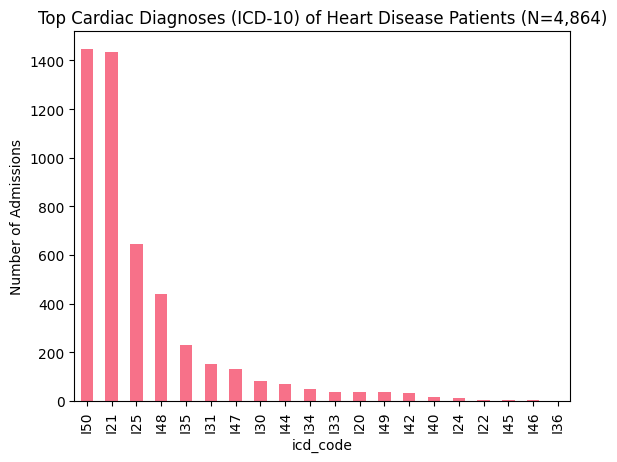

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt
df_counts = df1['icd_code'].value_counts()
df_counts.plot(kind='bar')
plt.title(f'Top Cardiac Diagnoses (ICD-10) of Heart Disease Patients (N={len(df1):,})')
plt.ylabel('Number of Admissions')
plt.show()
plt.savefig(out_dir / 'icd10_diagnoses_counts.png')

In [71]:
df1[["icd_code", "long_title"]].drop_duplicates().sort_values(by="icd_code")

,icd_code,long_title
195,I20,Angina pectoris
1,I21,Acute myocardial infarction
824,I22,Subsequent ST elevation (STEMI) and non-ST ele...
376,I24,Other acute ischemic heart diseases
6,I25,Chronic ischemic heart disease
116,I30,Acute pericarditis
31,I31,Other diseases of pericardium
42,I33,Acute and subacute endocarditis
524,I34,Nonrheumatic mitral valve disorders
4,I35,Nonrheumatic aortic valve disorders


| Code    | ICD-10 Title                                  | Description                            |
| ------- | --------------------------------------------- | -------------------------------------- |
| **I20** | Angina pectoris                               | Chest pain due to ischemia             |
| **I21** | Acute myocardial infarction                   | Heart attack                           |
| **I22** | Subsequent myocardial infarction              | Repeat MI episode                      |
| **I24** | Other acute ischemic heart diseases           | Temporary coronary insufficiency, etc. |
| **I25** | Chronic ischemic heart disease                | Stable coronary disease                |
| **I30** | Acute pericarditis                            | Inflammation of heart membrane         |
| **I31** | Other pericardial diseases                    | Chronic pericarditis, effusion         |
| **I33** | Acute endocarditis                            | Heart valve infection                  |
| **I34** | Nonrheumatic mitral valve disorders           | Valve regurgitation/stenosis           |
| **I35** | Nonrheumatic aortic valve disorders           | Aortic valve disease                   |
| **I36** | Nonrheumatic tricuspid valve disorders        | Tricuspid insufficiency                |
| **I40** | Acute myocarditis                             | Inflammation of heart muscle           |
| **I42** | Cardiomyopathy                                | Structural heart muscle disease        |
| **I44** | Atrioventricular and left bundle-branch block | Electrical conduction delay            |
| **I45** | Other conduction disorders                    | Conduction block types                 |
| **I46** | Cardiac arrest                                | Sudden stop of heart                   |
| **I47** | Paroxysmal tachycardia                        | Fast heart rhythm                      |
| **I48** | Atrial fibrillation and flutter               | Irregular heartbeat                    |
| **I49** | Other cardiac arrhythmias                     | Extrasystoles, premature beats         |
| **I50** | Heart failure                                 | Pumping dysfunction                    |


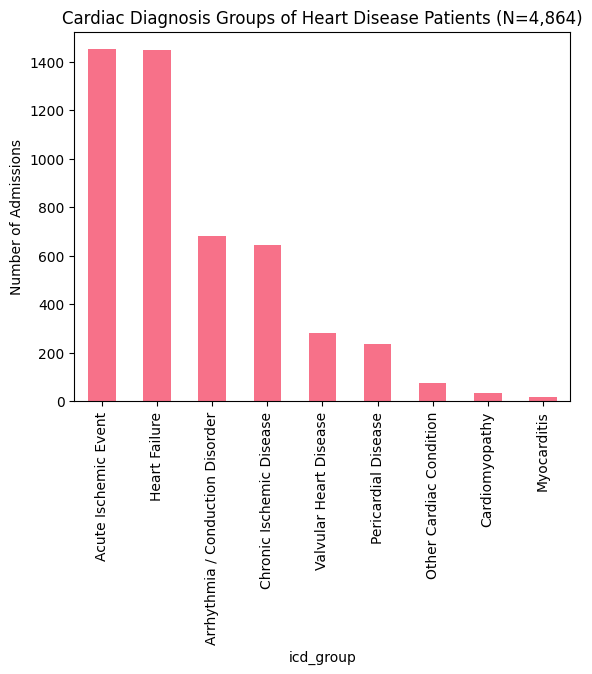

<Figure size 640x480 with 0 Axes>

In [67]:
# ICD group mapping function
def map_icd_group(code):
    if code.startswith('I50'):
        return 'Heart Failure'
    elif code in ['I21', 'I22', 'I24']:
        return 'Acute Ischemic Event'
    elif code.startswith('I25'):
        return 'Chronic Ischemic Disease'
    elif code in ['I44', 'I45', 'I46', 'I47', 'I48', 'I49']:
        return 'Arrhythmia / Conduction Disorder'
    elif code in ['I34', 'I35', 'I36']:
        return 'Valvular Heart Disease'
    elif code in ['I30', 'I31']:
        return 'Pericardial Disease'
    elif code == 'I42':
        return 'Cardiomyopathy'
    elif code == 'I40':
        return 'Myocarditis'
    else:
        return 'Other Cardiac Condition'

# Apply mapping
df1['icd_group'] = df1['icd_code'].apply(map_icd_group)
df1['icd_group'].value_counts().plot(kind='bar')
plt.title(f'Cardiac Diagnosis Groups of Heart Disease Patients (N={len(df1):,})')
plt.ylabel('Number of Admissions')
plt.show()
plt.savefig(out_dir / 'icd10_diagnoses_groups_counts.png')

Ratio between the number of tests flagged as abnormal and the total number 
of tests?

In [ ]:
df1[""]

### LaboratoryDF analysis
- maybe remove qc_flag == FAIL 
- maybe also WARN 
- how to handle NaNs in flag, value, valuenum, ... => remove or keep?
- rename flag NaN ==> "no abnormality == normal" 

- check per 'label' = test name the valuenum with valueuom! => maybe reaclc so all have same unit of measuremtn!; BUT 500 label is too many so...
- group by high level examination_group: Higher-level group for the test (Chemistry, Hematology, …);
- then maybe filter to take test that occur in >= x % of addmissions
- focus on cardiac relevant test => heart

- (group by fluid type - blood urine) ...

- group by analysis_batch_id? => matters for technical bias from instruments, check by plotting boxplot per batch sns.boxplot(x='analysis_batch_id', y='valuenum', data=df[df['label']=='Creatinine'])

- check progress of illness of timer => 'charttime'


Data cleaning

Remove implausible values using ref ranges (ref_range_lower, ref_range_upper)

Handle duplicates and QC issues (qc_flag)

Normalization

Log-transform skewed lab values (e.g., troponin)

Standardize across tests (z-scores)

Aggregation

Per-patient or per-diagnosis median value per test or per test group

Integration with ICD

Join on hadm_id to bring in ICD diagnosis categories

Use it for grouping (e.g., compare lab distributions for I50 vs I21


In [126]:
df2.columns, df2.shape

(Index(['hadm_id', 'charttime', 'value', 'valuenum', 'valueuom',
        'ref_range_lower', 'ref_range_upper', 'flag', 'label', 'fluid',
        'examination_group', 'analysis_batch_id', 'qc_flag', 'ref_range'],
       dtype='object'),
 (978503, 14))

In [132]:
df2["hadm_id"].value_counts()

hadm_id
21332395.0    4591
26941902.0    4516
28062533.0    3440
27261448.0    2898
29018732.0    2707
              ... 
22867350.0       5
28096037.0       5
26955996.0       4
23679591.0       4
24820749.0       3
Name: count, Length: 4752, dtype: int64

In [ ]:
# TODO 

In [4]:
df2[50:200].head(5)

,hadm_id,charttime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,label,fluid,examination_group,analysis_batch_id,qc_flag,ref_range
50,29654838.0,2188-01-06 09:09:00,107,107.0,mEq/L,96.0,108.0,NaN,Chloride,Blood,BMP,BATCH_218801_O4,OK,NaN
51,29654838.0,2188-01-06 09:09:00,1.4,1.4,mg/dL,0.4,1.1,abnormal,Creatinine,Blood,BMP,BATCH_218801_U4,OK,NaN
52,29654838.0,2188-01-06 09:09:00,___,138.0,mg/dL,70.0,100.0,abnormal,Glucose,Blood,BMP,BATCH_218801_B1,OK,NaN
53,29654838.0,2188-01-06 09:09:00,1.8,1.8,mg/dL,1.6,2.6,NaN,Magnesium,Blood,Renal Function Tests,BATCH_218801_F9,OK,NaN
54,29654838.0,2188-01-06 09:09:00,5.3,5.3,mg/dL,2.7,4.5,abnormal,Phosphate,Blood,Renal Function Tests,BATCH_218801_N7,OK,NaN


In [5]:
# count NaN values per column
df2.isna().sum()

hadm_id                   0
charttime                 0
value                 44478
valuenum              71186
valueuom              93918
ref_range_lower      112959
ref_range_upper      112959
flag                 634816
label                     0
fluid                     0
examination_group         0
analysis_batch_id         0
qc_flag                   0
ref_range            832288
dtype: int64

In [ ]:
# TODO look at top 10ish
df2["label"].value_counts()

label
Glucose                    39744
Potassium                  37859
Sodium                     36712
Chloride                   36612
Creatinine                 35939
                           ...  
Urine Fat Bodies               1
Blue Top Hold Frozen           1
Phenytoin, Free                1
Phenytoin, Percent Free        1
Hematocrit, Ascites            1
Name: count, Length: 502, dtype: int64

In [ ]:
# TODO look at top 
df2["examination_group"].value_counts()

examination_group
Complete Blood Count (CBC)    286407
BMP                           280773
Renal Function Tests          101250
Blood Gas                      83046
Coagulation and Hemostasis     61845
                               ...  
LUC                                1
Homocysteine                       1
Miscellaneous, Ascites             1
Myelocytes                         1
Hematocrit, Ascites                1
Name: count, Length: 202, dtype: int64

In [ ]:
# TODO keep only top 3
df2["fluid"].value_counts()

fluid
Blood                  918188
Urine                   56691
Pleural                  1881
Other Body Fluid         1350
Ascites                   188
Joint Fluid               141
Cerebrospinal Fluid        36
Stool                      15
Bone Marrow                13
Name: count, dtype: int64

In [6]:
#  flag: Abnormality indicator;
df2["flag"].value_counts()

flag
abnormal    343687
Name: count, dtype: int64

only take data where qc is OK

In [7]:
# qc_flag: Quality control flag;  
df2["qc_flag"].value_counts()

qc_flag
OK      880809
WARN     78124
FAIL     19570
Name: count, dtype: int64

Throw out bad quality data

In [42]:
#check where qc_flag is OK, the flag
df2_only_ok_qc = df2[(df2["qc_flag"]=="OK") | (df2["qc_flag"]=="WARN")]
df2_only_ok_qc["flag"].value_counts(), df2_only_ok_qc.shape, df2.shape

(flag
 abnormal    336854
 Name: count, dtype: int64,
 (958933, 14),
 (978503, 14))

In [9]:
# count NaN values per column
df2_only_ok_qc.isna().sum()

hadm_id                   0
charttime                 0
value                 43608
valuenum              69768
valueuom              92072
ref_range_lower      110729
ref_range_upper      110729
flag                 622079
label                     0
fluid                     0
examination_group         0
analysis_batch_id         0
qc_flag                   0
ref_range            815619
dtype: int64

rename NaNs in flag as no abnormality

In [ ]:
# rename Nanas in flag col as "normal"
df2_only_ok_qc["flag"] = df2_only_ok_qc["flag"].fillna("normal")
# TODO only fill if the valuenum is within the ref range!
df2_only_ok_qc["flag"].value_counts()

flag
normal      622079
abnormal    336854
Name: count, dtype: int64

In [13]:
df2_only_ok_qc.isna().sum()

hadm_id                   0
charttime                 0
value                 43608
valuenum              69768
valueuom              92072
ref_range_lower      110729
ref_range_upper      110729
flag                      0
label                     0
fluid                     0
examination_group         0
analysis_batch_id         0
qc_flag                   0
ref_range            815619
dtype: int64

In [64]:
df2["valueuom"].unique()

array(['IU/L', 'ng/mL', nan, 'sec', '%', 'mg/dL', 'mEq/L', 'Ratio',
       'g/dL', 'pg', 'fL', 'K/uL', 'm/uL', 'pg/mL', 'uIU/mL', 'ng/dL',
       'mm Hg', 'units', 'mOsm/kg', 'ug/dL', 'mg/L', 'mm/hr', '#/hpf',
       '#/lpf', ' ', 'mg/mg', 'mmol/L', 'U', '/hpf', 'ug/mL', '#/uL',
       'mg/24hr', 'mL', 'L/min', 'mg/g', 'umol/L', 'mIU/mL', 'IU/mL',
       'log10 IU/mL', 'U/mL', 'GPL', 'MPL', 'ng/mL FEU',
       'log10 copies/mL', '+/-', 'U/g/Hb', 'log10 cop/mL', 'Pos/Neg'],
      dtype=object)

#### some random ideas

check the "label" => we can then examine the value_num by grouping it with the ICD code 

In [14]:
df2["label"].unique()

array(['Creatine Kinase (CK)', 'Creatine Kinase, MB Isoenzyme',
       'Troponin T', 'INR(PT)', 'PT', 'PTT', '% Hemoglobin A1c', 'eAG',
       'Anion Gap', 'Bicarbonate', 'Calcium, Total', 'Chloride',
       'Cholesterol Ratio (Total/HDL)', 'Cholesterol, HDL',
       'Cholesterol, LDL, Calculated', 'Cholesterol, Total', 'Creatinine',
       'Glucose', 'Magnesium', 'Phosphate', 'Potassium', 'Sodium',
       'Triglycerides', 'Urea Nitrogen', 'Hematocrit', 'Hemoglobin',
       'MCH', 'MCHC', 'MCV', 'Platelet Count', 'RDW', 'Red Blood Cells',
       'White Blood Cells', 'Alanine Aminotransferase (ALT)',
       'Asparate Aminotransferase (AST)', 'Albumin',
       'Alkaline Phosphatase', 'Amylase', 'Bilirubin, Direct',
       'Bilirubin, Indirect', 'Bilirubin, Total', 'Vitamin B12',
       'Basophils', 'Eosinophils', 'Lymphocytes', 'Monocytes',
       'Neutrophils', 'EDTA Hold', 'Red Top Hold', 'CK-MB Index',
       'Thyroid Stimulating Hormone', 'Thyroxine (T4), Free',
       'Base Excess',

maybe group by hadm id?

check technical bias by addmission id, If strong shifts occur → apply batch correction (e.g., z-score per batch). E.g. Creatinine

<Axes: xlabel='analysis_batch_id', ylabel='valuenum'>

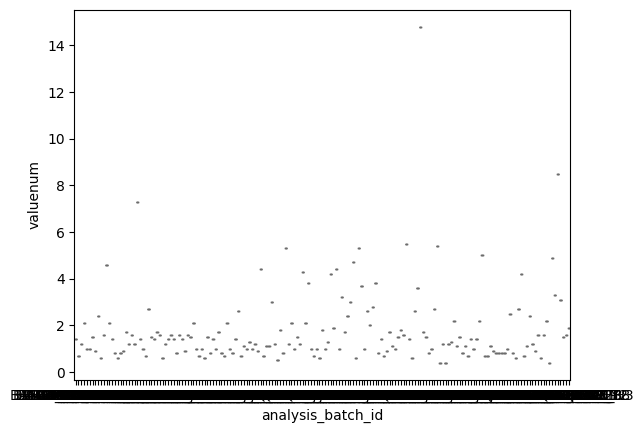

In [22]:
sns.boxplot(x='analysis_batch_id', y='valuenum', data=df2_only_ok_qc[df2_only_ok_qc['label']=='Creatinine'][::200])


 maybe group by examination_group: Higher-level group for the test (Chemistry, Hematology, …);

In [15]:
df2_only_ok_qc["examination_group"].value_counts()

examination_group
Complete Blood Count (CBC)    280662
BMP                           275127
Renal Function Tests           99177
Blood Gas                      81426
Coagulation and Hemostasis     60675
                               ...  
Promyelocytes                      1
LUC                                1
Homocysteine                       1
Miscellaneous, Ascites             1
Myelocytes                         1
Name: count, Length: 201, dtype: int64

In [16]:
df2_only_ok_qc.shape

(958933, 14)

In [18]:
# Sort df2_only_ok_qc by examination_group (case-insensitive), put NaNs last
df2_sorted = df2_only_ok_qc.sort_values(
    by='examination_group',
    key=lambda s: s.astype(str).str.lower().fillna(''),
    na_position='last'
).reset_index(drop=True)

# Show up to 20 rows per examination_group
df2_sorted.groupby('examination_group').head(20)

,hadm_id,charttime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,label,fluid,examination_group,analysis_batch_id,qc_flag,ref_range
0,24912593.0,2162-12-13 21:04:00,555,555.0,#/uL,578.0,1850.0,abnormal,Absolute CD3 Count,Blood,Absolute CD3 Count,BATCH_216212_V9,OK,Normal range: 3-5
1,28660165.0,2199-01-28 16:10:00,1204,1204.0,#/uL,578.0,1850.0,normal,Absolute CD3 Count,Blood,Absolute CD3 Count,BATCH_219901_Z6,OK,NaN
2,23281464.0,2176-11-22 09:07:00,991,991.0,#/uL,578.0,1850.0,normal,Absolute CD3 Count,Blood,Absolute CD3 Count,BATCH_217611_N4,OK,NaN
3,21905656.0,2132-10-04 08:40:00,475,475.0,#/uL,578.0,1850.0,abnormal,Absolute CD3 Count,Blood,Absolute CD3 Count,BATCH_213210_V8,OK,Normal range: 10-20
4,21135197.0,2182-08-11 09:25:00,658,658.0,#/uL,578.0,1850.0,normal,Absolute CD3 Count,Blood,Absolute CD3 Count,BATCH_218208_M6,OK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958814,26020563.0,2113-08-23 20:07:00,NaN,NaN,NaN,NaN,NaN,normal,Voided Specimen,Blood,Voided Specimen,BATCH_211308_U9,WARN,Normal range: 3-5
958815,21472555.0,2164-08-12 09:45:00,NaN,NaN,NaN,NaN,NaN,normal,Voided Specimen,Blood,Voided Specimen,BATCH_216408_C4,OK,NaN
958816,29017807.0,2163-12-21 17:22:00,NaN,NaN,NaN,NaN,NaN,normal,Voided Specimen,Blood,Voided Specimen,BATCH_216312_H9,OK,NaN
958817,25568984.0,2117-04-14 09:00:00,NaN,NaN,NaN,NaN,NaN,normal,Voided Specimen,Blood,Voided Specimen,BATCH_211704_W3,OK,NaN


In [25]:
df_grouped = df2_only_ok_qc.groupby(['hadm_id', 'examination_group'])['valuenum'].median().unstack()
df_grouped.head(20)

examination_group,ADP,ANCA Titer,ARCH-1,Absolute CD3 Count,Absolute CD4 Count,Absolute CD8 Count,Acetone,"Albumin, Ascites","Albumin, Body Fluid","Albumin, Pleural",...,"Triglycerides, Ascites","Triglycerides, Pleural",Tumor Markers,Uptake Ratio,"Urea Nitrogen, Body Fluid",Urine Test,Virology,Vitamin and Nutritional Studies,Voided Specimen,"proBNP, Pleural"
hadm_id,,,,,,,,,,,,,,,,,,,,,
20004456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20007905.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.3,1.9,...,NaN,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN
20013519.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20013602.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20014999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20015883.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.000,NaN,158.5,NaN,NaN
20015927.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.000,NaN,NaN,NaN,NaN
20021932.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,14.500,NaN,NaN,NaN,NaN
20022560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### feautre engineering

In [67]:
# Filter glucose measurements
glucose_df = df2[df2['label'].str.contains('glucose', case=False, na=False)]
# check for same unit
glucose_df['valueuom'].value_counts()

valueuom
mg/dL    39956
Name: count, dtype: int64

In [66]:
max_glucose_per_adm = glucose_df.groupby('hadm_id')['valuenum'].max()
df2['max_glucose'] = df2['hadm_id'].map(max_glucose_per_adm)
df2[['hadm_id', 'max_glucose']]

,hadm_id,max_glucose
0,29654838.0,138.0
1,29654838.0,138.0
2,29654838.0,138.0
3,29654838.0,138.0
4,29654838.0,138.0
...,...,...
978498,21557581.0,116.0
978499,21557581.0,116.0
978500,21557581.0,116.0
978501,21557581.0,116.0


 Total count of laboratory events linked to the admission? 

In [60]:
lab_count_per_adm = df2.groupby('hadm_id').size()
df2['n_lab_events'] = df2['hadm_id'].map(lab_count_per_adm)
df2[['hadm_id', 'n_lab_events']]

,hadm_id,n_lab_events
0,29654838.0,59
1,29654838.0,59
2,29654838.0,59
3,29654838.0,59
4,29654838.0,59
...,...,...
978498,21557581.0,181
978499,21557581.0,181
978500,21557581.0,181
978501,21557581.0,181


 Ratio of abnormal tests per admission

In [61]:
df2['is_abnormal'] = df2['flag'].str.contains('abnormal', case=False, na=False)
abnormal_ratio_per_adm = df2.groupby('hadm_id')['is_abnormal'].mean()  # mean = ratio of True values
df2['abnormal_ratio'] = df2['hadm_id'].map(abnormal_ratio_per_adm)
df2[['hadm_id', 'abnormal_ratio']]

,hadm_id,abnormal_ratio
0,29654838.0,0.423729
1,29654838.0,0.423729
2,29654838.0,0.423729
3,29654838.0,0.423729
4,29654838.0,0.423729
...,...,...
978498,21557581.0,0.436464
978499,21557581.0,0.436464
978500,21557581.0,0.436464
978501,21557581.0,0.436464


In [62]:
df2.describe()

,hadm_id,valuenum,ref_range_lower,ref_range_upper,max_glucose,n_lab_events,abnormal_ratio
count,9.785030e+05,907317.000000,865544.000000,865544.000000,978031.000000,978503.000000,978503.000000
mean,2.504395e+07,67.332325,31.724619,55.794861,222.421620,489.194346,0.351238
std,2.868159e+06,2175.589189,44.840840,400.515033,152.701422,616.325238,0.103759
min,2.000446e+07,-743.000000,0.000000,0.000000,46.000000,3.000000,0.000000
25%,2.261232e+07,4.300000,3.300000,5.400000,138.000000,164.000000,0.285266
50%,2.510567e+07,17.000000,10.400000,20.000000,178.000000,307.000000,0.357143
75%,2.749772e+07,60.200000,36.000000,52.000000,253.000000,554.000000,0.428571
max,2.999967e+07,886449.000000,2200.000000,100000.000000,1190.000000,4591.000000,1.000000


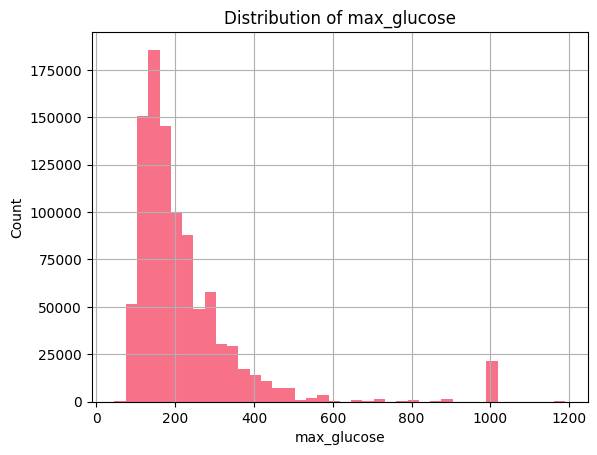

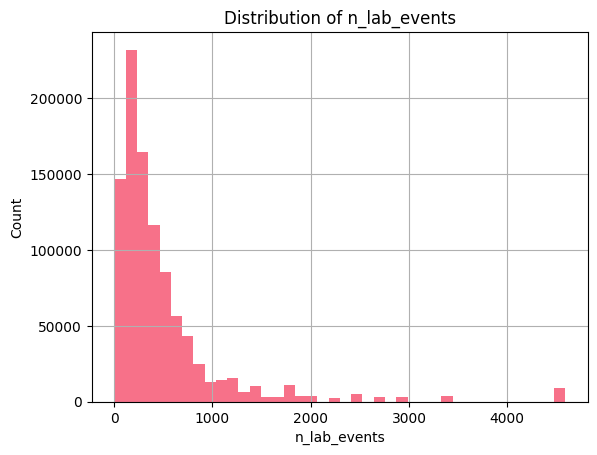

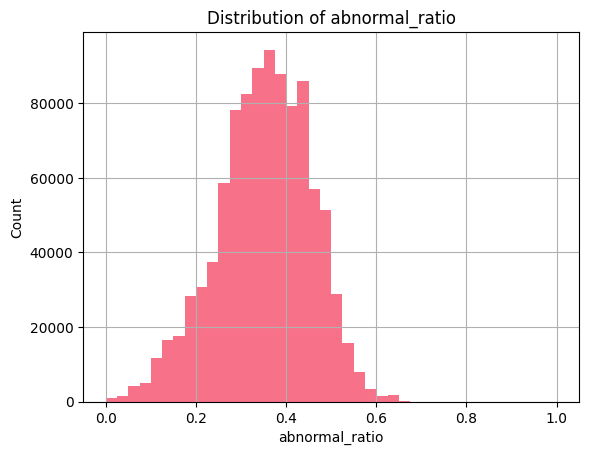

In [68]:
import matplotlib.pyplot as plt

features = ['max_glucose', 'n_lab_events', 'abnormal_ratio']

for col in features:
    plt.figure()
    df2[col].hist(bins=40)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

### Microbi0logy Events DF Analysis
first we link the heart and lab datasets.
Then, for those admissions with infection-suspected diagnoses => We merge in microbiology_events on hadm_id.

In [76]:
df3.columns

Index(['subject_id', 'hadm_id', 'chartdate', 'charttime', 'spec_type_desc',
       'test_name', 'org_name', 'ab_name', 'dilution_text',
       'dilution_comparison', 'dilution_value', 'interpretation',
       'technician_id', 'qc_flag'],
      dtype='object')

In [74]:
df3.describe()

,subject_id,hadm_id,dilution_value
count,1.558700e+04,1.558700e+04,4711.000000
mean,1.522098e+07,2.503469e+07,7.062420
std,2.910238e+06,2.846364e+06,21.245298
min,1.000098e+07,2.000790e+07,0.060000
25%,1.266277e+07,2.266346e+07,0.500000
50%,1.519823e+07,2.514649e+07,1.000000
75%,1.772189e+07,2.743116e+07,4.000000
max,1.999767e+07,2.999967e+07,512.000000


In [92]:
df3

,subject_id,hadm_id,chartdate,charttime,spec_type_desc,test_name,org_name,ab_name,dilution_text,dilution_comparison,dilution_value,interpretation,technician_id,qc_flag,n_micro_exam
0,10000980,26913865.0,2189-06-27 00:00:00,2189-06-27 10:52:00,MRSA SCREEN,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN,NaN,TECH_063,QC_OK,1
1,10002155,23822395.0,2129-08-04 00:00:00,2129-08-04 17:04:00,MRSA SCREEN,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN,NaN,TECH_095,QC_OK,12
2,10002155,23822395.0,2129-08-05 00:00:00,2129-08-05 15:54:00,URINE,Legionella Urinary Antigen,NaN,NaN,NaN,NaN,NaN,NaN,TECH_083,QC_OK,12
3,10002155,23822395.0,2129-08-05 00:00:00,2129-08-05 18:43:00,SPUTUM,GRAM STAIN,NaN,NaN,NaN,NaN,NaN,NaN,TECH_095,QC_OK,12
4,10002155,23822395.0,2129-08-05 00:00:00,2129-08-05 18:43:00,SPUTUM,RESPIRATORY CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,TECH_077,QC_OK,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15581,19997664,25289714.0,2186-01-02 00:00:00,2186-01-02 03:40:00,MRSA SCREEN,MRSA SCREEN,NaN,NaN,NaN,NaN,NaN,NaN,TECH_049,QC_OK,2
15582,19997665,26052266.0,2173-11-09 00:00:00,2173-11-09 18:09:00,Staph aureus swab,Staph aureus Screen,NaN,NaN,NaN,NaN,NaN,NaN,TECH_051,QC_OK,5
15583,19997666,24256422.0,2168-08-03 00:00:00,2168-08-03 22:00:00,BLOOD CULTURE,"Blood Culture, Routine",NaN,NaN,NaN,NaN,NaN,NaN,TECH_086,QC_OK,6
15585,19997668,20329436.0,2129-08-12 00:00:00,2129-08-12 15:56:00,CATHETER TIP-IV,WOUND CULTURE,NaN,NaN,NaN,NaN,NaN,NaN,TECH_061,QC_OK,10


Highest value of glucose per admission

In [82]:
for col in ['spec_type_desc', 'test_name', 'org_name', 'ab_name', 'dilution_text',  'dilution_comparison', 'interpretation','technician_id', 'qc_flag']:
    print(col, df3[col].unique())

spec_type_desc ['MRSA SCREEN' 'URINE' 'SPUTUM' 'STOOL' 'SEROLOGY/BLOOD' 'SWAB'
 'BLOOD CULTURE' 'Rapid Respiratory Viral Screen & Culture'
 'FLUID RECEIVED IN BLOOD CULTURE BOTTLES' 'FLUID,OTHER'
 'Staph aureus swab' 'THROAT FOR STREP' 'PLEURAL FLUID' 'Blood (CMV AB)'
 'Influenza A/B by DFA' 'PERITONEAL FLUID' 'TISSUE' 'IMMUNOLOGY'
 'ASPIRATE' 'BLOOD CULTURE ( MYCO/F LYTIC BOTTLE)'
 'BRONCHOALVEOLAR LAVAGE' 'CSF;SPINAL FLUID' 'Blood (EBV)' 'Blood (Toxo)'
 'CATHETER TIP-IV' 'CRE Screen' 'BRONCHIAL WASHINGS' 'Blood (LYME)'
 'JOINT FLUID' 'DIRECT ANTIGEN TEST FOR VARICELLA-ZOSTER VIRUS'
 'Direct Antigen Test for Herpes Simplex Virus Types 1 & 2'
 'Immunology (CMV)' 'Mini-BAL' 'STOOL (RECEIVED IN TRANSPORT SYSTEM)'
 'THROAT CULTURE' 'BILE' 'DIALYSIS FLUID' 'BRONCHIAL BRUSH'
 'SKIN SCRAPINGS' 'ABSCESS' 'FOREIGN BODY' 'EAR']
test_name ['MRSA SCREEN' 'Legionella Urinary Antigen ' 'GRAM STAIN'
 'RESPIRATORY CULTURE' 'ACID FAST SMEAR' 'ACID FAST CULTURE'
 'CLOSTRIDIUM DIFFICILE TOXIN A & B TEST

In [89]:
for col in [ 'dilution_text', 'dilution_comparison', 'interpretation','technician_id', 'qc_flag']:
    print(col, df3[col].unique())

dilution_text [nan '8' '<=1' '<=16' '<=0.25' '=>8' '<=0.5' '2' '1' '=>4' '<=4' '<=2'
 '=>16' '0.25' '=>64' '=>32' '=>128' '=>0.5' '16' '32' '<=0.12' '4' '0.5'
 '64' '128' '256' '3' '<=0.06' '=>2' '=>512' '>256' '<=8']
dilution_comparison [nan '=         ' '<=        ' '=>        ']
interpretation [nan 'R' 'S' 'I']
technician_id ['TECH_063' 'TECH_095' 'TECH_083' 'TECH_077' 'TECH_068' 'TECH_084'
 'TECH_013' 'TECH_033' 'TECH_023' 'TECH_102' 'TECH_011' 'TECH_079'
 'TECH_098' 'TECH_041' 'TECH_024' 'TECH_112' 'TECH_085' 'TECH_017'
 'TECH_065' 'TECH_118' 'TECH_004' 'TECH_101' 'TECH_026' 'TECH_018'
 'TECH_081' 'TECH_120' 'TECH_076' 'TECH_046' 'TECH_093' 'TECH_034'
 'TECH_074' 'TECH_028' 'TECH_014' 'TECH_116' 'TECH_091' 'TECH_042'
 'TECH_107' 'TECH_037' 'TECH_080' 'TECH_054' 'TECH_043' 'TECH_032'
 'TECH_053' 'TECH_096' 'TECH_070' 'TECH_086' 'TECH_056' 'TECH_057'
 'TECH_072' 'TECH_103' 'TECH_025' 'TECH_051' 'TECH_073' 'TECH_119'
 'TECH_016' 'TECH_104' 'TECH_022' 'TECH_062' 'TECH_019' 'TECH_010'


remove qc fail

In [84]:
df3.shape

(15587, 15)

In [87]:
df3 = df3[df3["qc_flag"] != "QC_FAIL"]
df3.shape

(14808, 15)

total count of microbiology examinations for the admission? 

In [91]:
me_count_per_adm = df3.groupby('hadm_id').size()
df3['n_micro_exam'] = df3['hadm_id'].map(me_count_per_adm)
df3[['hadm_id', 'subject_id', 'n_micro_exam']]

,hadm_id,subject_id,n_micro_exam
0,26913865.0,10000980,1
1,23822395.0,10002155,12
2,23822395.0,10002155,12
3,23822395.0,10002155,12
4,23822395.0,10002155,12
...,...,...,...
15581,25289714.0,19997664,2
15582,26052266.0,19997665,5
15583,24256422.0,19997666,6
15585,20329436.0,19997668,10


### Procedure codes df

In [93]:
df4.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'chartdate', 'icd_code',
       'long_title'],
      dtype='object')

In [94]:
df4.describe()

,subject_id,hadm_id,seq_num
count,1.449700e+04,1.449700e+04,14497.000000
mean,1.496070e+07,2.506208e+07,3.661102
std,2.892130e+06,2.857570e+06,2.841640
min,1.000098e+07,2.000790e+07,1.000000
25%,1.249274e+07,2.268042e+07,2.000000
50%,1.486272e+07,2.507288e+07,3.000000
75%,1.745891e+07,2.750236e+07,5.000000
max,1.999850e+07,2.999967e+07,28.000000


In [135]:
df4.head(20)

,subject_id,hadm_id,seq_num,chartdate,icd_code,long_title
0,10000980,26913865,1,2189-07-01 03:00:00,0066,Percutaneous transluminal coronary angioplasty...
1,10000980,26913865,2,2189-07-01 03:00:00,3607,Insertion of drug-eluting coronary artery sten...
2,10000980,26913865,3,2189-07-01 03:00:00,0045,Insertion of one vascular stent
3,10000980,26913865,4,2189-07-01 03:00:00,0041,Procedure on two vessels
4,10000980,26913865,5,2189-07-01 03:00:00,3722,Left heart cardiac catheterization
5,10000980,26913865,6,2189-07-01 03:00:00,8856,Coronary arteriography using two catheters
6,10000980,26913865,7,2189-07-01 03:00:00,0044,Procedure on vessel bifurcation
7,10002013,24760295,1,2160-07-12 03:00:00,3722,Left heart cardiac catheterization
8,10002013,24760295,2,2160-07-12 03:00:00,8856,Coronary arteriography using two catheters
9,10002155,23822395,1,2129-08-05 03:00:00,0066,Percutaneous transluminal coronary angioplasty...


 Total count of procedure codes linked to the admission? 

In [137]:
# Group by hadm_id, count number of procedure rows per admission
proc_count = df4.groupby('hadm_id').size().reset_index(name='total_procedures')
proc_count

,hadm_id,total_procedures
0,20007905,5
1,20014999,3
2,20015927,2
3,20021932,7
4,20022560,5
...,...,...
3454,29968754,6
3455,29970039,8
3456,29986749,7
3457,29998994,6


In [ ]:
proc_count.isna().sum()

hadm_id             0
total_procedures    0
dtype: int64

ICD code analysis

In [154]:
# Count frequency of each procedure code
proc_dist = proc['icd_code'].value_counts()#.reset_index()
proc_dist.columns = ['icd_code', 'count']
proc_dist.head(10)  # top 20 most frequent codes

icd_code
8856       1603
0066       1020
3722        975
0040        848
3607        685
0045        596
3723        431
B211YZZ     405
9920        313
3606        269
Name: count, dtype: int64

KeyboardInterrupt: 

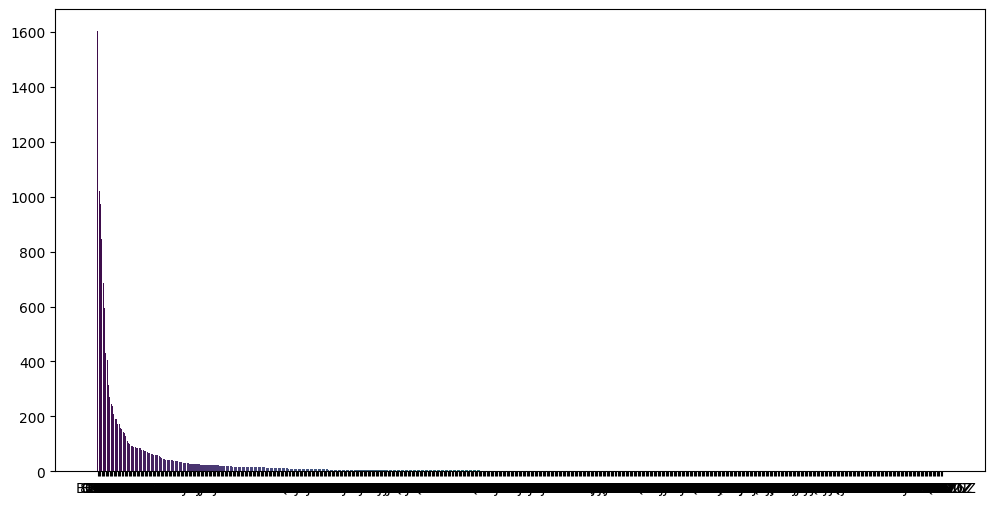

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=proc_dist.head(15).index, y=proc_dist.head(15).values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel('ICD Procedure Code')
plt.ylabel('Count')
plt.title('Top Procedure Codes Distribution')
plt.tight_layout()
plt.show()

gorup icd code by first char

In [152]:
proc['icd_group'] = proc['icd_code'].astype(str).str[0]  # first character
group_dist = proc['icd_group'].value_counts().reset_index()
group_dist.columns = ['icd_group', 'count']
group_dist

,icd_group,count
0,3,4605
1,0,4390
2,8,2861
3,9,1048
4,B,664
5,5,448
6,4,420
7,2,27
8,1,19
9,7,12


dsitr per admission

In [151]:
proc_per_adm = proc.groupby(['hadm_id', 'icd_code']).size().reset_index(name='count')
proc_per_adm

,hadm_id,icd_code,count
0,20007905,3404,1
1,20007905,3491,1
2,20007905,370,1
3,20007905,8964,1
4,20007905,8968,1
...,...,...,...
14033,29999670,0041,1
14034,29999670,0046,1
14035,29999670,0066,1
14036,29999670,3606,1


### Box PLots for numerical values

Creating box plots for all numeric features...
Heart Diagnoses: 3 suitable numeric features
Laboratory Events: 3 suitable numeric features
Microbiology Events: 1 suitable numeric features
Procedure Codes: 1 suitable numeric features

Total features to plot: 8

Plotting Heart Diagnoses...

Plotting Laboratory Events...

Plotting Microbiology Events...

Plotting Procedure Codes...

Saved: all_datasets_boxplots.jpg


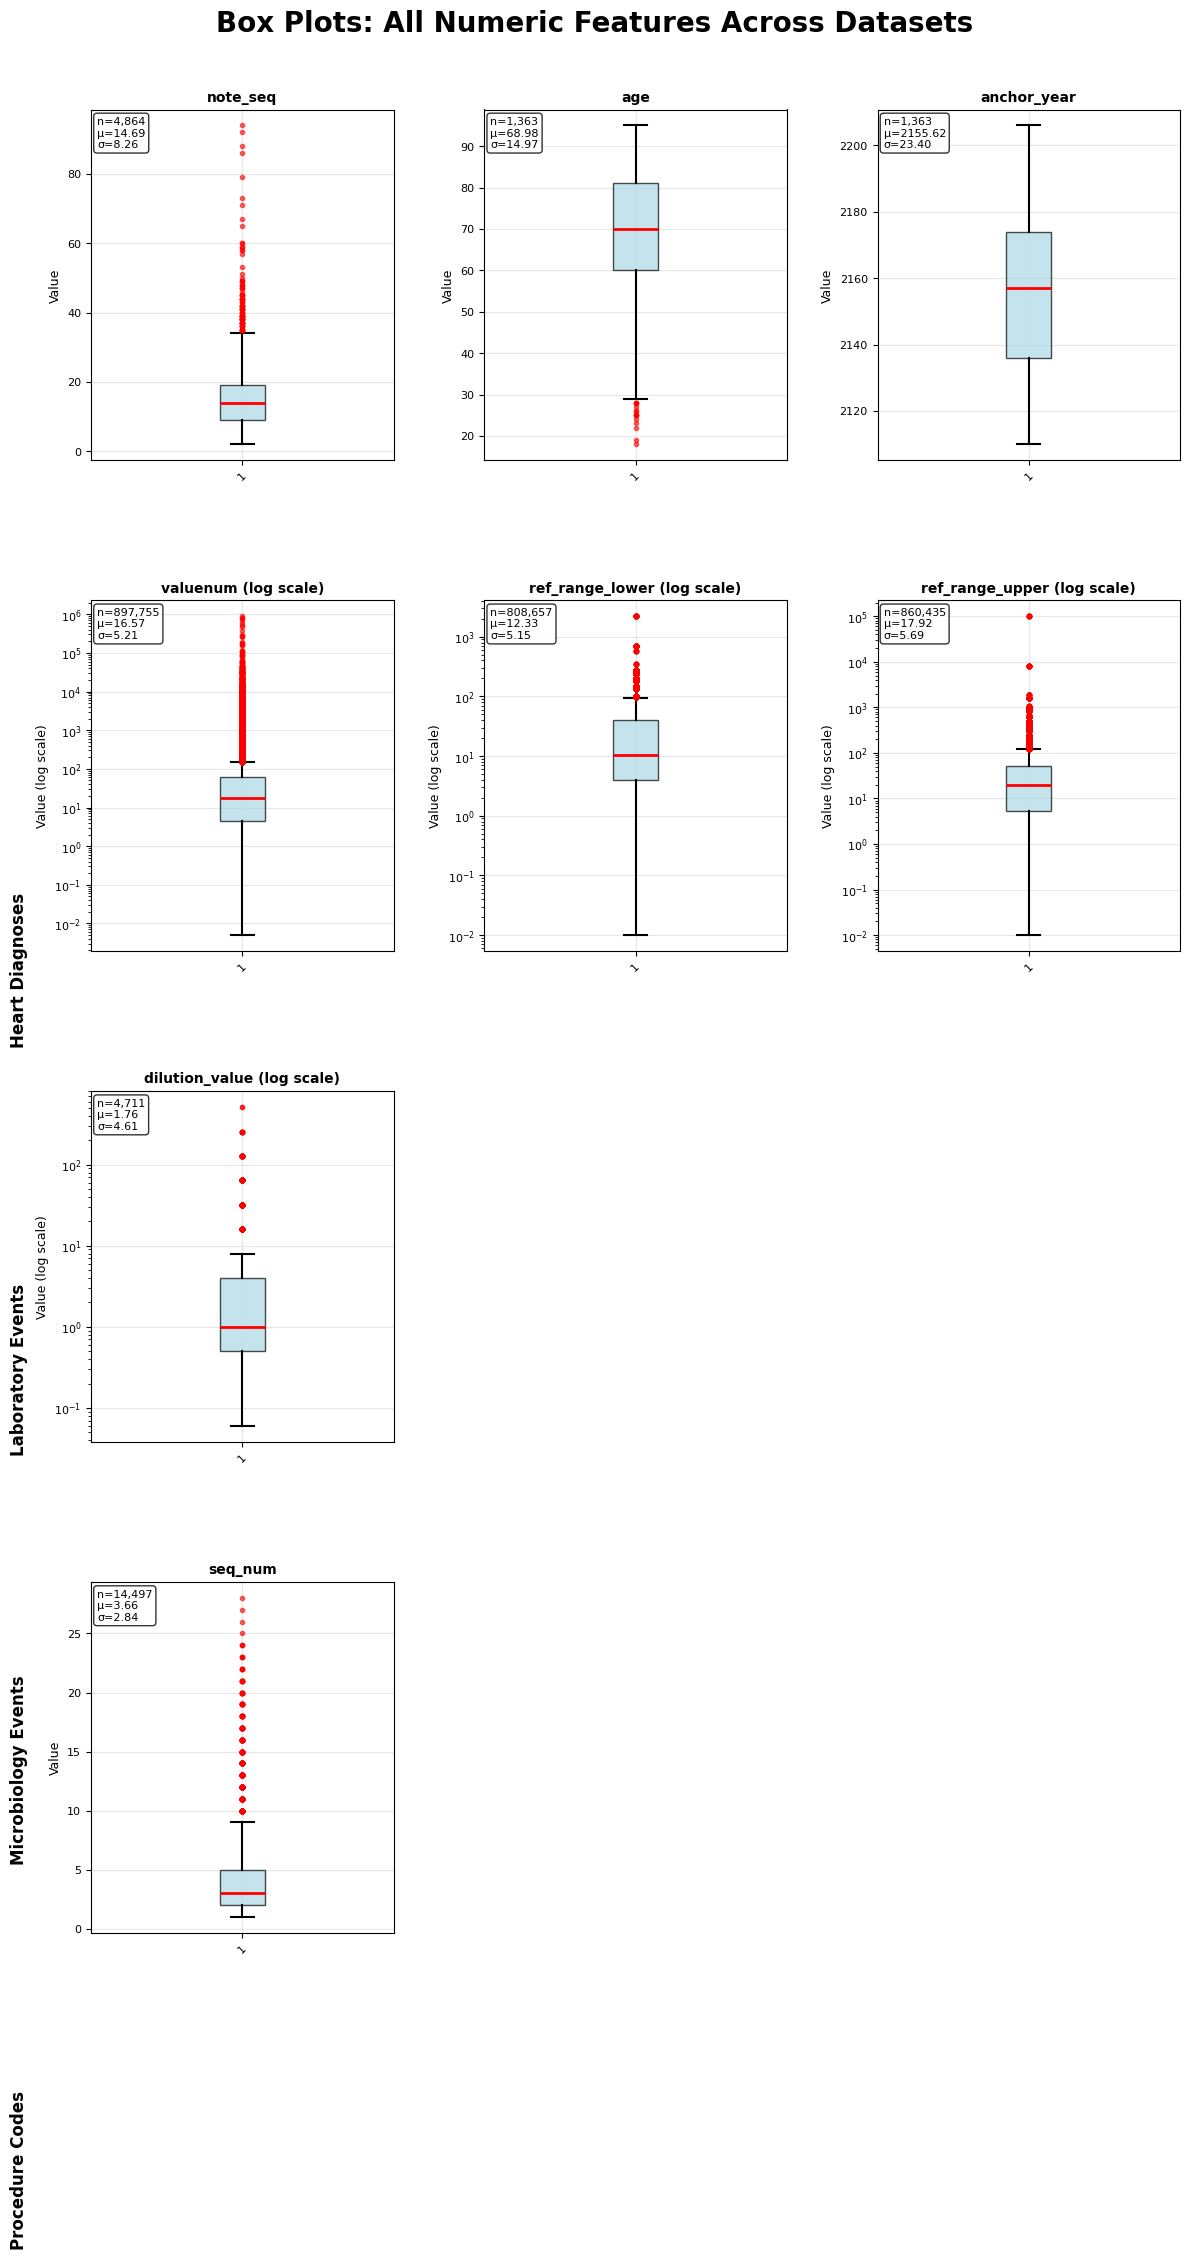


Box plot summary:
Heart Diagnoses: 3 features plotted
  • note_seq: n=4,864, range=[2.00, 94.00]
  • age: n=1,363, range=[18.00, 95.00]
  • anchor_year: n=1,363, range=[2110.00, 2206.00]
Laboratory Events: 3 features plotted
  • valuenum: n=907,317, range=[-743.00, 886449.00]
  • ref_range_lower: n=865,544, range=[0.00, 2200.00]
  • ref_range_upper: n=865,544, range=[0.00, 100000.00]
Microbiology Events: 1 features plotted
  • dilution_value: n=4,711, range=[0.06, 512.00]
Procedure Codes: 1 features plotted
  • seq_num: n=14,497, range=[1.00, 28.00]

Box plot analysis complete!


In [4]:
# Create comprehensive box plots for all numeric features across datasets
print("Creating box plots for all numeric features...")
print("="*80)

# Define columns to exclude (ID columns)
exclude_columns = ['subject_id', 'hadm_id', 'subject_id_dx']

# Define columns that should use log scale
log_scale_columns = ['valuenum', 'ref_range_lower', 'ref_range_upper', 'dilution_value']

# Collect all numeric features from all datasets
all_numeric_features = {}
for dataset_name, df in dfs.items():
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Filter out ID columns and other excluded columns
    suitable_cols = []
    for col in numeric_cols:
        # Skip excluded columns
        if col.lower() in [col.lower() for col in exclude_columns]:
            continue
        
        # TODO check if this is a suitable condition!
        # Check for high cardinality (ID-like columns)
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio < 0.95:  # Less than 95% unique values
            suitable_cols.append(col)
    
    all_numeric_features[dataset_name] = suitable_cols
    print(f"{dataset_name}: {len(suitable_cols)} suitable numeric features")

# Calculate total number of features for subplot layout
total_features = sum(len(features) for features in all_numeric_features.values())
print(f"\nTotal features to plot: {total_features}")

# Create a large figure with subplots
# Calculate grid dimensions
n_datasets = len(all_numeric_features)
max_features_per_dataset = max(len(features) for features in all_numeric_features.values())

# Create subplots - one row per dataset
fig, axes = plt.subplots(n_datasets, max_features_per_dataset, 
                        figsize=(max_features_per_dataset * 4, n_datasets * 5))
fig.suptitle('Box Plots: All Numeric Features Across Datasets', 
             fontsize=20, fontweight='bold', y=0.98)

# Ensure axes is 2D
if n_datasets == 1:
    axes = axes.reshape(1, -1)
if max_features_per_dataset == 1:
    axes = axes.reshape(-1, 1)

# Plot each dataset's features
for dataset_idx, (dataset_name, features) in enumerate(all_numeric_features.items()):
    print(f"\nPlotting {dataset_name}...")
    
    for feature_idx, feature in enumerate(features):
        ax = axes[dataset_idx, feature_idx]
        
        # Get data for this feature
        data = dfs[dataset_name][feature].dropna()
        
        # Apply log scale if this column should use it
        use_log_scale = feature.lower() in [col.lower() for col in log_scale_columns]
        
        if len(data) > 0:
            # Filter out non-positive values for log scale
            if use_log_scale:
                data = data[data > 0]  # Only positive values for log scale
                if len(data) == 0:
                    ax.text(0.5, 0.5, 'No positive values\nfor log scale', ha='center', va='center', 
                           transform=ax.transAxes, fontsize=10)
                    ax.set_title(f'{feature} (No Positive Data)', fontsize=10)
                    continue
            
            # Create box plot
            box_plot = ax.boxplot(data, patch_artist=True, 
                                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                                 medianprops=dict(color='red', linewidth=2),
                                 whiskerprops=dict(color='black', linewidth=1.5),
                                 capprops=dict(color='black', linewidth=1.5),
                                 flierprops=dict(marker='o', markerfacecolor='red', 
                                               markeredgecolor='red', markersize=3, alpha=0.6))
            
            # Apply log scale to y-axis if needed
            if use_log_scale:
                ax.set_yscale('log')
                ylabel = f'Value (log scale)'
            else:
                ylabel = 'Value'
            
            # Add statistics text
            if use_log_scale:
                stats_text = f'n={len(data):,}\nμ={np.exp(np.log(data).mean()):.2f}\nσ={np.exp(np.log(data).std()):.2f}'
            else:
                stats_text = f'n={len(data):,}\nμ={data.mean():.2f}\nσ={data.std():.2f}'
            
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', fontsize=8, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            # Customize plot
            title = f'{feature}' + (' (log scale)' if use_log_scale else '')
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_ylabel(ylabel, fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if needed
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', 
                   transform=ax.transAxes, fontsize=10)
            ax.set_title(f'{feature} (No Data)', fontsize=10)
    
    # Hide empty subplots in this row
    for feature_idx in range(len(features), max_features_per_dataset):
        axes[dataset_idx, feature_idx].set_visible(False)
    
    # Add dataset label on the left
    fig.text(0.02, 0.5 - (dataset_idx * 0.8 / n_datasets), 
             f'{dataset_name}', rotation=90, fontsize=12, fontweight='bold',
             ha='center', va='center')

plt.tight_layout()
plt.subplots_adjust(left=0.08, top=0.93, hspace=0.4, wspace=0.3)

# Save the plot
try:
    filepath = out_dir / "all_datasets_boxplots.jpg"
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\nSaved: all_datasets_boxplots.jpg")
except Exception as e:
    print(f"\nCould not save plot: {e}")

plt.show()

# Print summary statistics
print(f"\nBox plot summary:")
print("="*80)
for dataset_name, features in all_numeric_features.items():
    print(f"{dataset_name}: {len(features)} features plotted")
    for feature in features:
        data = dfs[dataset_name][feature].dropna()
        if len(data) > 0:
            print(f"  • {feature}: n={len(data):,}, range=[{data.min():.2f}, {data.max():.2f}]")

print(f"\nBox plot analysis complete!")


## 6.2 time

In [4]:
# Comprehensive data overview for all datasets
def analyze_dataset(df, name):
    """Analyze a single dataset and return key information"""
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    
    # Basic info
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print(f"\nData Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    
    print(f"\nMissing Values:")
    if missing.sum() == 0:
        print("  No missing values")
    else:
        missing_summary = pd.DataFrame({
            'Missing Count': missing,
            'Missing %': missing_pct
        }).sort_values('Missing Count', ascending=False)
        print(missing_summary[missing_summary['Missing Count'] > 0].head(10))
    
    # Sample data
    print(f"\nSample Data:")
    print(df.head(3).to_string())
    
    return {
        'shape': df.shape,
        'dtypes': df.dtypes,
        'missing': missing,
        'sample': df.head(3)
    }

# Analyze all datasets
dataset_info = {}
for name, df in dfs.items():
    dataset_info[name] = analyze_dataset(df, name)

print(f"\nSummary: Analyzed {len(dataset_info)} datasets")



HEART DIAGNOSES
Shape: 4,864 rows × 25 columns


Memory usage: 31.11 MB

Data Types:
  object: 19 columns
  int64: 4 columns
  float64: 2 columns

Missing Values:
                 Missing Count  Missing %
dod                       4466      91.82
anchor_year               3501      71.98
age                       3501      71.98
gender                    3501      71.98
chief_complaint             12       0.25
invasions                   12       0.25

Sample Data:
          note_id  subject_id   hadm_id note_type  note_seq            charttime            storetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## 3. Distribution Analysis

Now we'll create distribution plots for numerical variables in each dataset to understand the data patterns and characteristics.


In [96]:
# Utility function to create clean distribution plots
def create_distribution_plots(df, dataset_name, max_vars=4):
    """
    Create distribution plots for numerical variables in a dataset
    
    Parameters:
    - df: DataFrame to analyze
    - dataset_name: Name for the plot title and filename
    - max_vars: Maximum number of variables to plot
    """
    
    # Get numerical columns, excluding ID-like columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filter out ID-like columns (high cardinality)
    suitable_vars = []
    for col in numeric_cols:
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio < 0.8:  # Less than 80% unique values
            suitable_vars.append(col)
    
    if not suitable_vars:
        print(f"No suitable numerical variables found in {dataset_name}")
        return
    
    # Limit number of variables
    suitable_vars = suitable_vars[:max_vars]
    
    # Create subplots
    n_vars = len(suitable_vars)
    if n_vars == 1:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes = [axes]
    elif n_vars == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    elif n_vars == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    
    fig.suptitle(f'Distribution Analysis - {dataset_name}', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(suitable_vars):
        ax = axes[i]
        data = df[col].dropna()
        
        if len(data) > 0:
            # Create histogram
            ax.hist(data, bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')
            
            # Add statistics
            mean_val = data.mean()
            std_val = data.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
            
            ax.set_title(f'{col}\\n(n={len(data):,}, μ={mean_val:.2f}, σ={std_val:.2f})')
            ax.set_xlabel(col)
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
            ax.legend()
        else:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', transform=ax.transAxes)
    
    # Hide empty subplots
    for i in range(len(suitable_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Save plot
    try:
        filename = f"{dataset_name.lower().replace(' ', '_')}_distributions.jpg"
        filepath = out_dir / filename
        fig.savefig(filepath, dpi=200, bbox_inches='tight')
        print(f"Saved: {filename}")
    except Exception as e:
        print(f"Could not save plot: {e}")
    
    plt.show()
    
    return suitable_vars



Creating distribution plots for all datasets...

Analyzing Heart Diagnoses...
Saved: heart_diagnoses_distributions.jpg


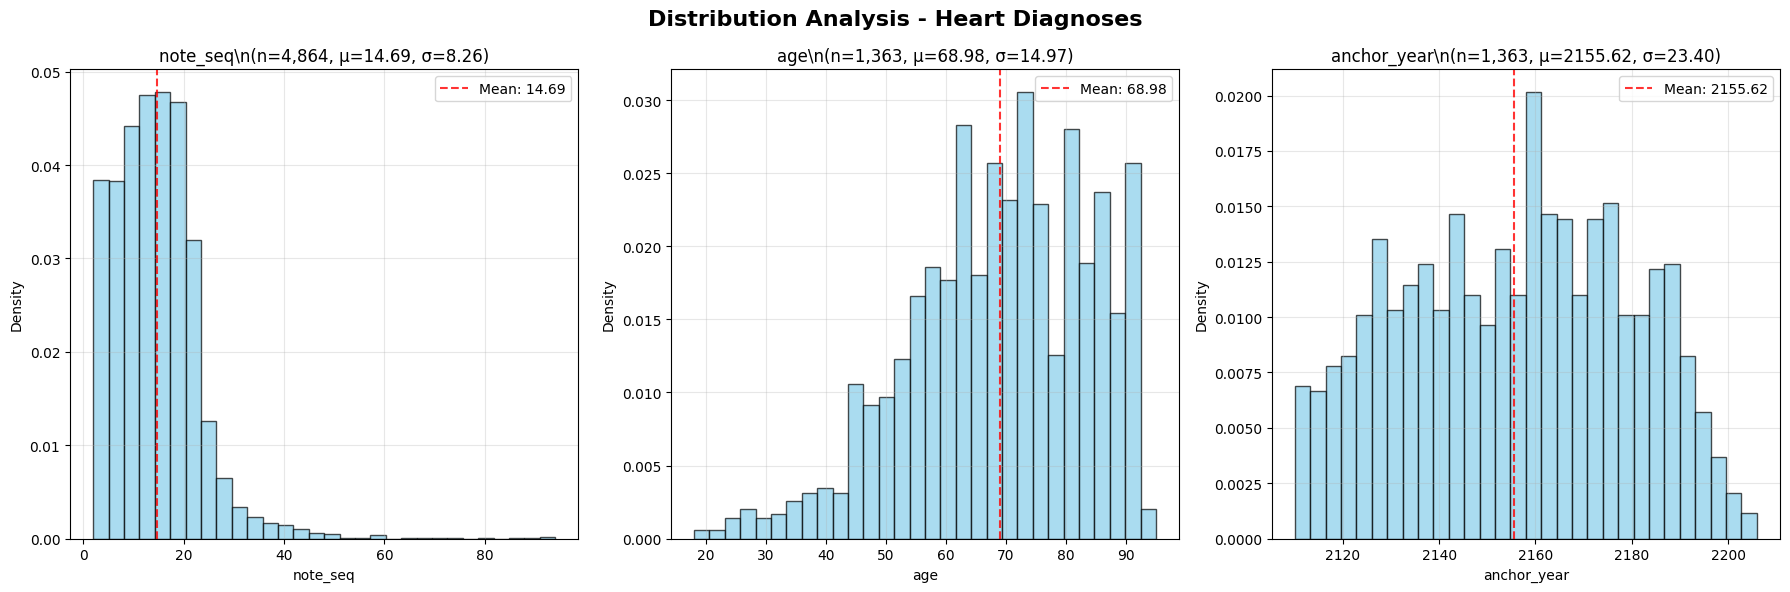


Analyzing Laboratory Events...
Saved: laboratory_events_distributions.jpg


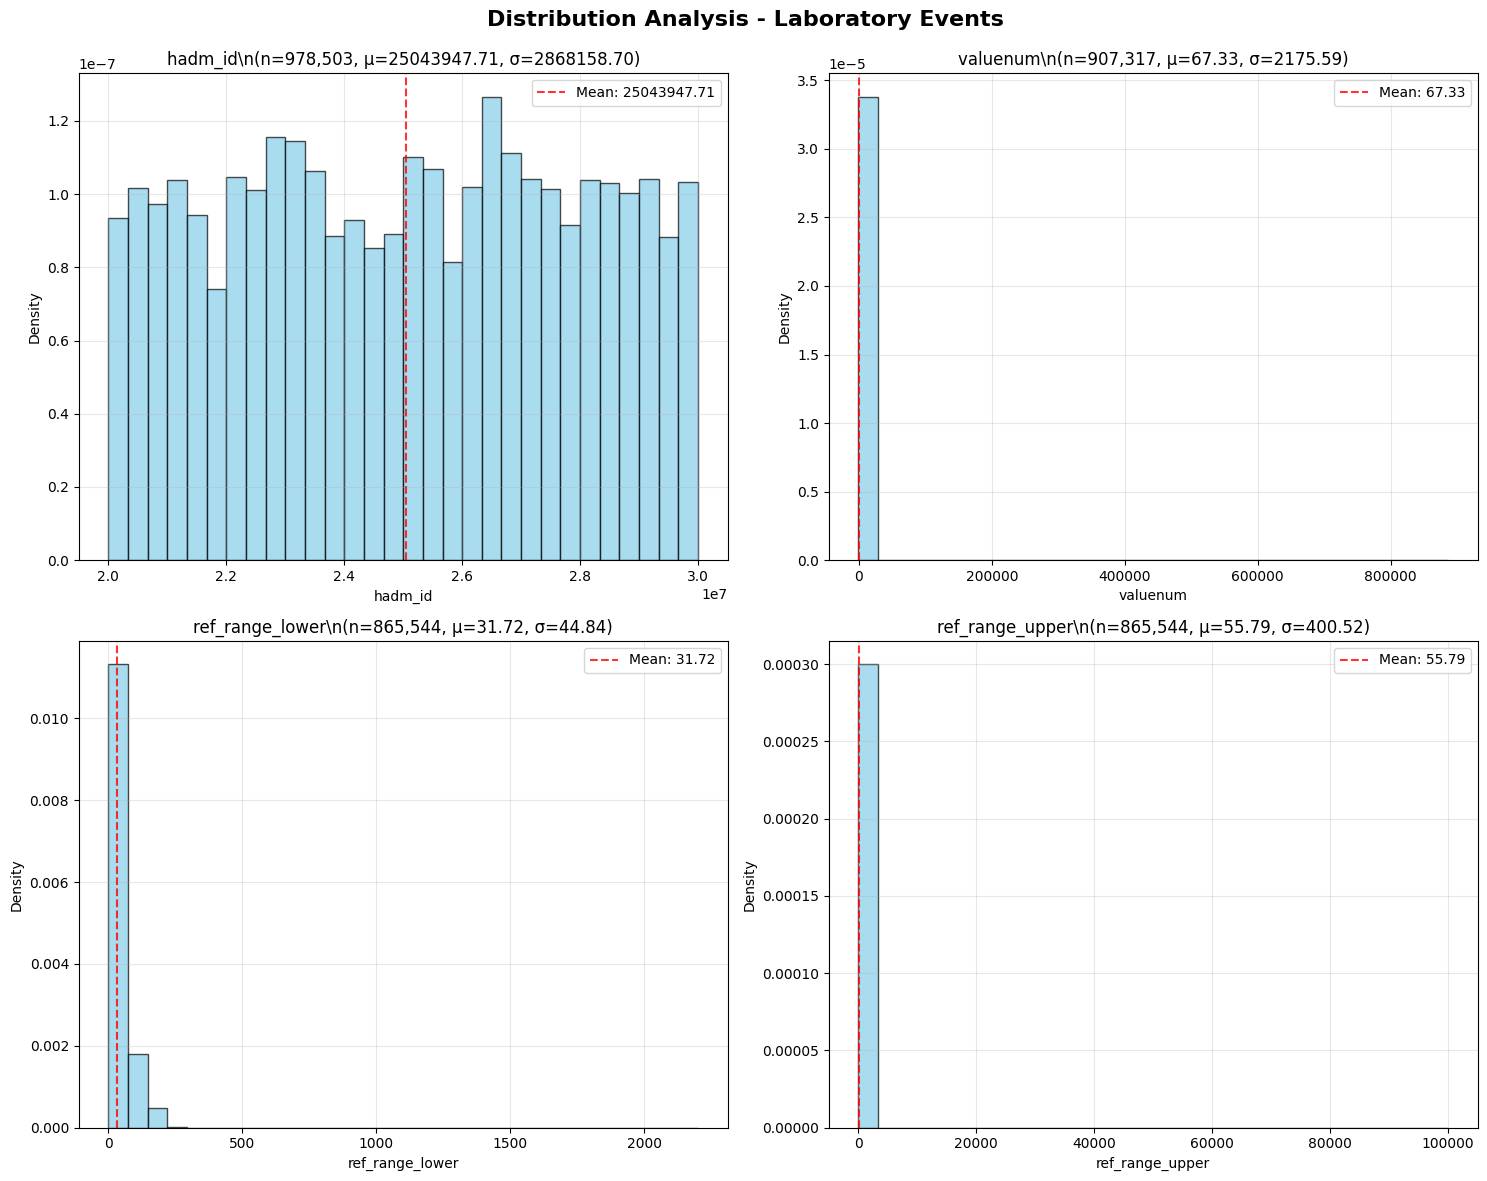


Analyzing Microbiology Events...
Saved: microbiology_events_distributions.jpg


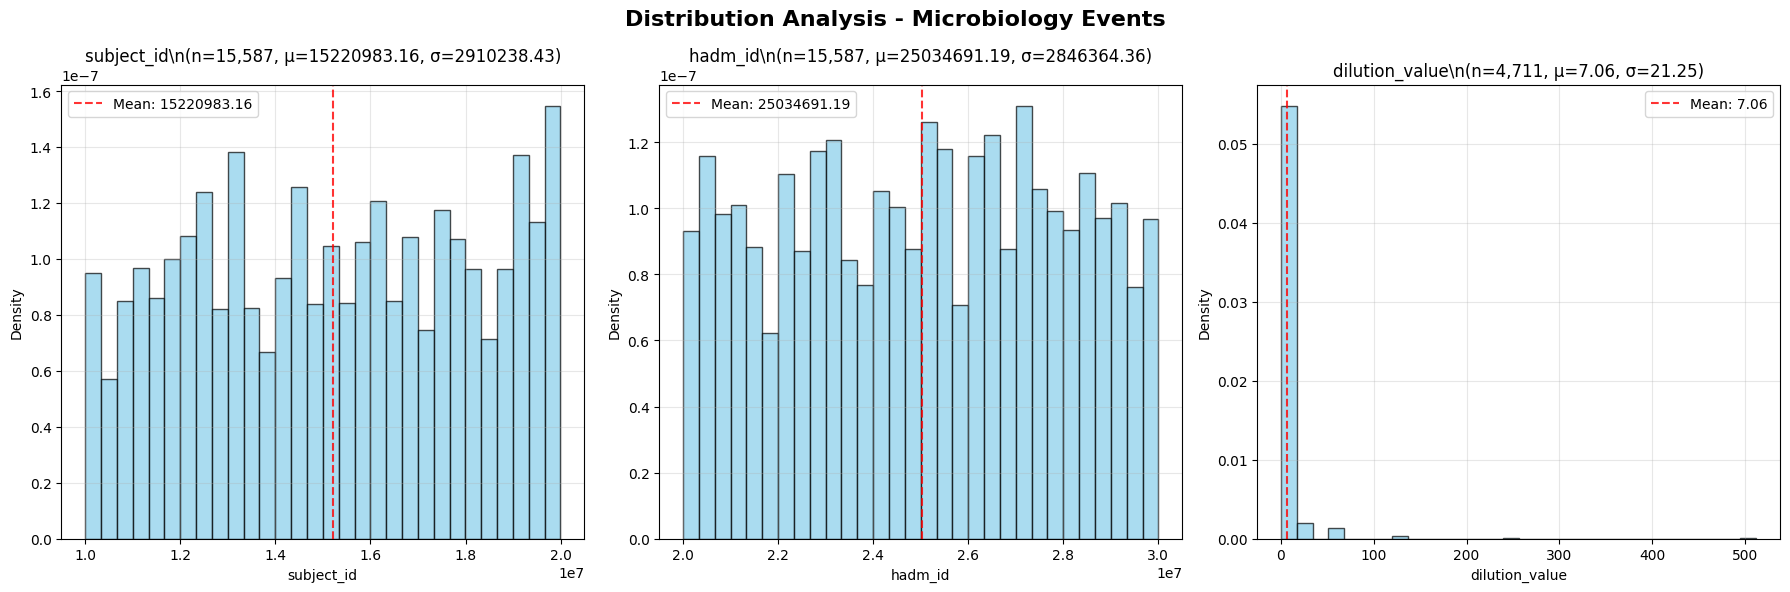


Analyzing Procedure Codes...
Saved: procedure_codes_distributions.jpg


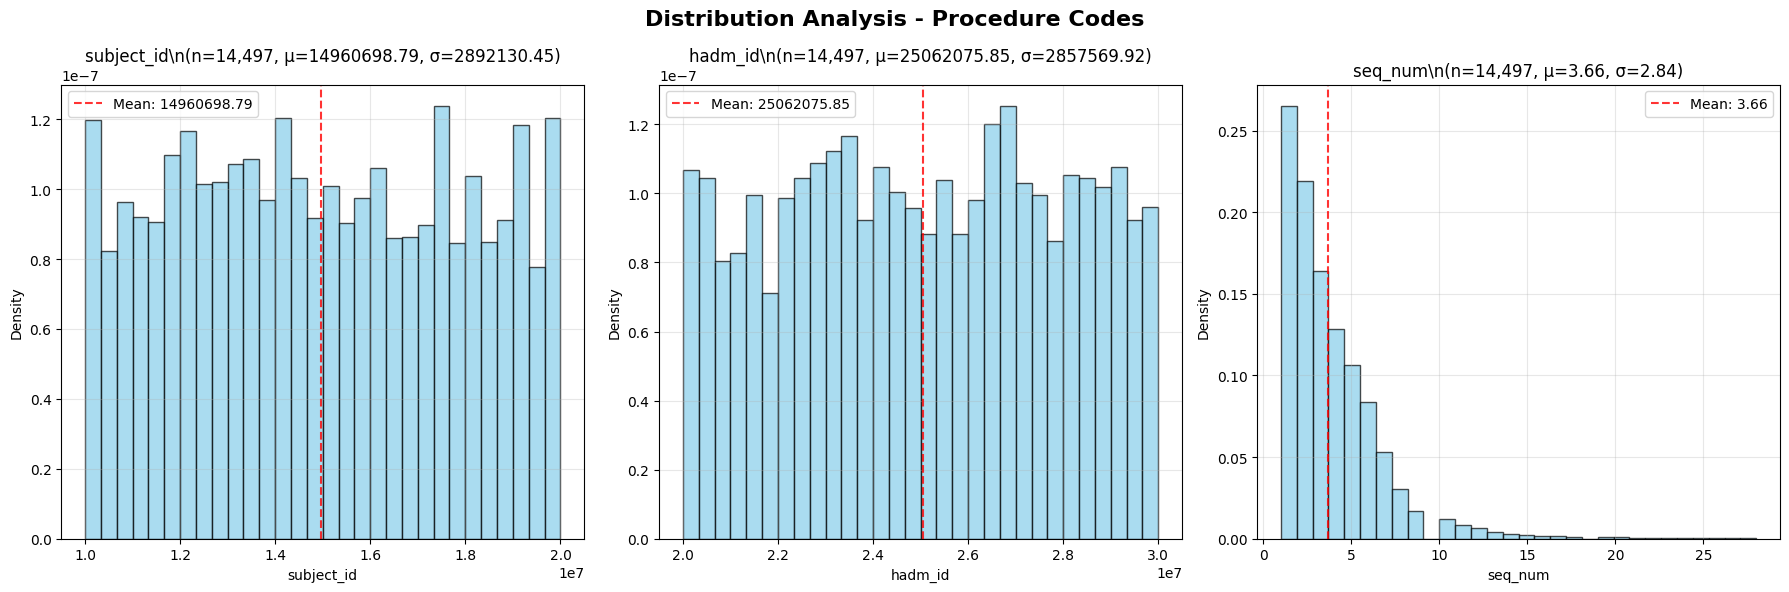


Distribution analysis complete!
Plotted variables summary:
  Heart Diagnoses: note_seq, age, anchor_year
  Laboratory Events: hadm_id, valuenum, ref_range_lower, ref_range_upper
  Microbiology Events: subject_id, hadm_id, dilution_value
  Procedure Codes: subject_id, hadm_id, seq_num


In [6]:
# Generate distribution plots for all datasets
print("Creating distribution plots for all datasets...")
print("="*60)

plotted_vars = {}
for name, df in dfs.items():
    print(f"\nAnalyzing {name}...")
    vars_plotted = create_distribution_plots(df, name)
    plotted_vars[name] = vars_plotted

print(f"\nDistribution analysis complete!")
print(f"Plotted variables summary:")
for dataset, vars_list in plotted_vars.items():
    if vars_list:
        print(f"  {dataset}: {', '.join(vars_list)}")
    else:
        print(f"  {dataset}: No suitable variables")


## 4. Focused Analysis: Heart Diagnoses Dataset

Let's perform a deeper analysis of the heart diagnoses dataset, focusing on key clinical variables like patient demographics, timing patterns, and diagnostic codes.


In [7]:
# Focused analysis on Heart Diagnoses dataset
def analyze_heart_diagnoses(df):
    """Perform detailed analysis of heart diagnoses dataset"""
    
    print("HEART DIAGNOSES DATASET - DETAILED ANALYSIS")
    print("="*60)
    
    # Create analysis copy
    df_analysis = df.copy()
    
    # 1. Convert datetime columns
    datetime_cols = ['charttime', 'storetime']
    for col in datetime_cols:
        if col in df_analysis.columns:
            df_analysis[f'{col}_dt'] = pd.to_datetime(df_analysis[col], errors='coerce')
            df_analysis[f'{col}_hour'] = df_analysis[f'{col}_dt'].dt.hour
            df_analysis[f'{col}_dayofweek'] = df_analysis[f'{col}_dt'].dt.dayofweek
    
    # 2. Process gender (categorical to numeric)
    if 'gender' in df_analysis.columns:
        df_analysis['gender_numeric'] = pd.Categorical(df_analysis['gender']).codes
        # Handle NaN values (they get code -1)
        df_analysis['gender_numeric'] = df_analysis['gender_numeric'].replace(-1, np.nan)
    
    # 3. Process age
    if 'age' in df_analysis.columns:
        df_analysis['age_numeric'] = pd.to_numeric(df_analysis['age'], errors='coerce')
    
    # 4. Process ICD codes
    if 'icd_code' in df_analysis.columns:
        # Create frequency encoding
        icd_counts = df_analysis['icd_code'].value_counts()
        df_analysis['icd_frequency'] = df_analysis['icd_code'].map(icd_counts)
        
        print(f"ICD Code Analysis:")
        print(f"  Total unique codes: {df_analysis['icd_code'].nunique()}")
        print(f"  Most common codes:")
        print(icd_counts.head(10).to_string())
    
    # 5. Create focused plots
    plot_vars = []
    
    # Time variables
    if 'storetime_hour' in df_analysis.columns:
        plot_vars.append('storetime_hour')
    
    # Demographic variables
    if 'gender_numeric' in df_analysis.columns:
        plot_vars.append('gender_numeric')
    if 'age_numeric' in df_analysis.columns:
        plot_vars.append('age_numeric')
    
    # Clinical variables
    if 'icd_frequency' in df_analysis.columns:
        plot_vars.append('icd_frequency')
    
    return df_analysis, plot_vars

# Perform focused analysis
heart_df_analysis, heart_plot_vars = analyze_heart_diagnoses(df1)

print(f"\nHeart diagnoses analysis complete!")
print(f"Variables prepared for plotting: {heart_plot_vars}")


HEART DIAGNOSES DATASET - DETAILED ANALYSIS
ICD Code Analysis:
  Total unique codes: 20
  Most common codes:
icd_code
I50    1447
I21    1434
I25     645
I48     438
I35     231
I31     153
I47     130
I30      83
I44      70
I34      50

Heart diagnoses analysis complete!
Variables prepared for plotting: ['storetime_hour', 'gender_numeric', 'age_numeric', 'icd_frequency']


Saved: task1.1_heart_diagnoses_analysis.jpg


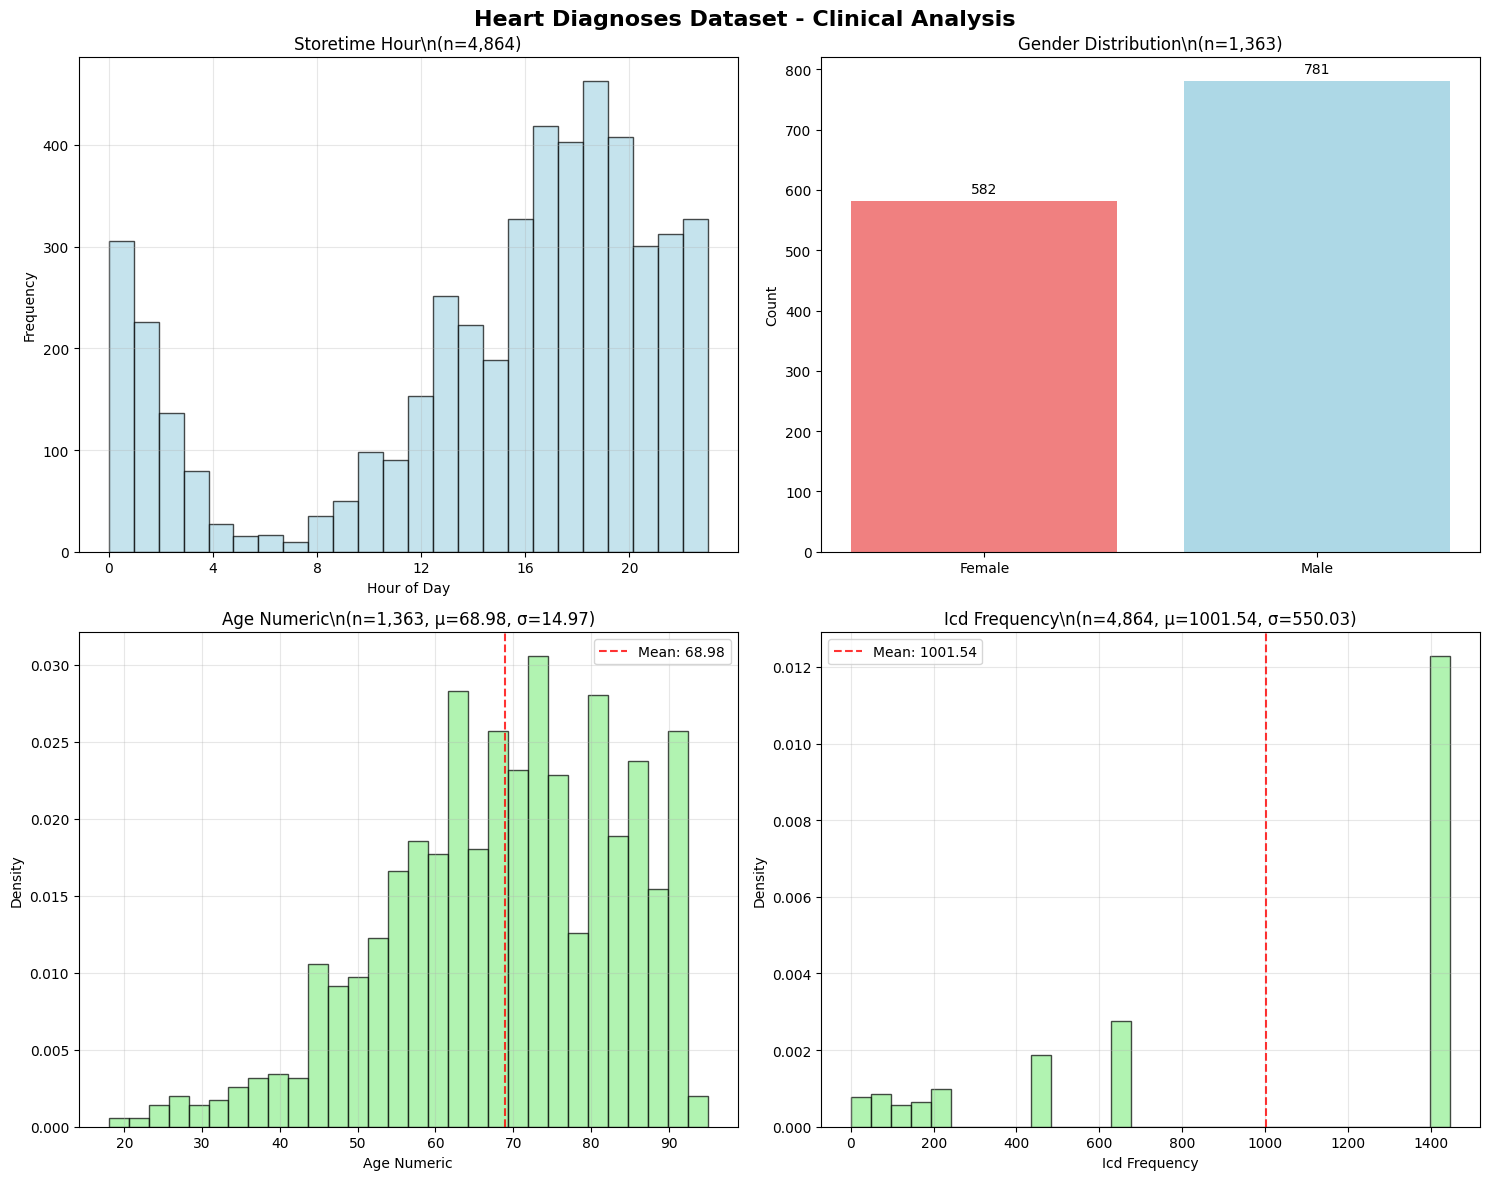

In [8]:
# Create specialized plots for heart diagnoses dataset
def plot_heart_diagnoses_analysis(df, plot_vars):
    """Create specialized plots for heart diagnoses analysis"""
    
    if not plot_vars:
        print("No variables to plot")
        return
    
    n_vars = len(plot_vars)
    
    # Create subplots
    if n_vars == 1:
        fig, axes = plt.subplots(1, 1, figsize=(10, 6))
        axes = [axes]
    elif n_vars == 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    elif n_vars == 3:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.flatten()
    
    fig.suptitle('Heart Diagnoses Dataset - Clinical Analysis', fontsize=16, fontweight='bold')
    
    for i, col in enumerate(plot_vars):
        ax = axes[i]
        data = df[col].dropna()
        
        if len(data) == 0:
            ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{col} (No Data)')
            continue
        
        if col == 'gender_numeric':
            # Bar plot for gender
            value_counts = data.value_counts().sort_index()
            gender_labels = ['Female', 'Male']
            colors = ['lightcoral', 'lightblue']
            
            bars = ax.bar(range(len(value_counts)), value_counts.values, color=colors[:len(value_counts)])
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(gender_labels[:len(value_counts)])
            ax.set_title(f'Gender Distribution\\n(n={len(data):,})')
            ax.set_ylabel('Count')
            
            # Add value labels on bars
            for bar, count in zip(bars, value_counts.values):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(value_counts.values)*0.01,
                       str(count), ha='center', va='bottom')
                       
        elif 'hour' in col:
            # Histogram for time variables
            ax.hist(data, bins=24, alpha=0.7, color='lightblue', edgecolor='black')
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel('Frequency')
            ax.set_title(f'{col.replace("_", " ").title()}\\n(n={len(data):,})')
            ax.set_xticks(range(0, 24, 4))
            ax.grid(True, alpha=0.3)
            
        else:
            # Histogram with statistics for continuous variables
            ax.hist(data, bins=30, alpha=0.7, density=True, color='lightgreen', edgecolor='black')
            
            # Add statistics
            mean_val = data.mean()
            std_val = data.std()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
            
            ax.set_title(f'{col.replace("_", " ").title()}\\n(n={len(data):,}, μ={mean_val:.2f}, σ={std_val:.2f})')
            ax.set_xlabel(col.replace('_', ' ').title())
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
            ax.legend()
    
    # Hide empty subplots
    for i in range(len(plot_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    
    # Save plot
    try:
        filepath = out_dir / "task1.1_heart_diagnoses_analysis.jpg"
        fig.savefig(filepath, dpi=200, bbox_inches='tight')
        print(f"Saved: task1.1_heart_diagnoses_analysis.jpg")
    except Exception as e:
        print(f"Could not save plot: {e}")
    
    plt.show()

# Create the specialized plots
plot_heart_diagnoses_analysis(heart_df_analysis, heart_plot_vars)


## 5. Summary and Conclusions




### Key Findings

Based on our exploratory data analysis, here are the main insights:

#### Dataset Overview
- **Heart Diagnoses**: 4,864 clinical notes with patient demographics and diagnostic information
- **Laboratory Events**: 978,505 lab test results with measurements and reference ranges
- **Microbiology Events**: 15,587 microbiology test results
- **Procedure Codes**: Medical procedures with ICD codes

#### Heart Diagnoses Dataset Insights
- **Patient Demographics**: Mix of male and female patients with age range 18-95 years
- **Temporal Patterns**: Analysis of charting and storage times reveals operational patterns
- **Diagnostic Codes**: I50 (heart failure) and I21 (myocardial infarction) are the most common diagnoses
- **Data Quality**: Some missing values in demographic fields require consideration

#### Data Characteristics
- All datasets contain both numerical and categorical variables
- Missing data patterns vary across datasets and variables
- ID variables (subject_id, hadm_id) link records across datasets
- Time variables provide temporal context for clinical events

### Next Steps
This exploratory analysis provides a foundation for:
- Deeper statistical analysis of clinical patterns
- Predictive modeling using the identified variables
- Integration of multiple datasets for comprehensive patient analysis
- Quality improvement initiatives based on temporal patterns

---
*Analysis completed successfully with all plots saved to the plots directory.*

Creating time series analysis for charttime and storetime...
Heart Diagnoses: ['charttime', 'storetime']
Laboratory Events: ['charttime']
Microbiology Events: ['charttime']

Found time columns in 3 datasets

Processing Heart Diagnoses...
  charttime: 4,864 valid timestamps
  storetime: 4,864 valid timestamps

Processing Laboratory Events...
  charttime: 978,503 valid timestamps

Processing Microbiology Events...
  charttime: 15,587 valid timestamps

Saved: time_series_analysis.jpg


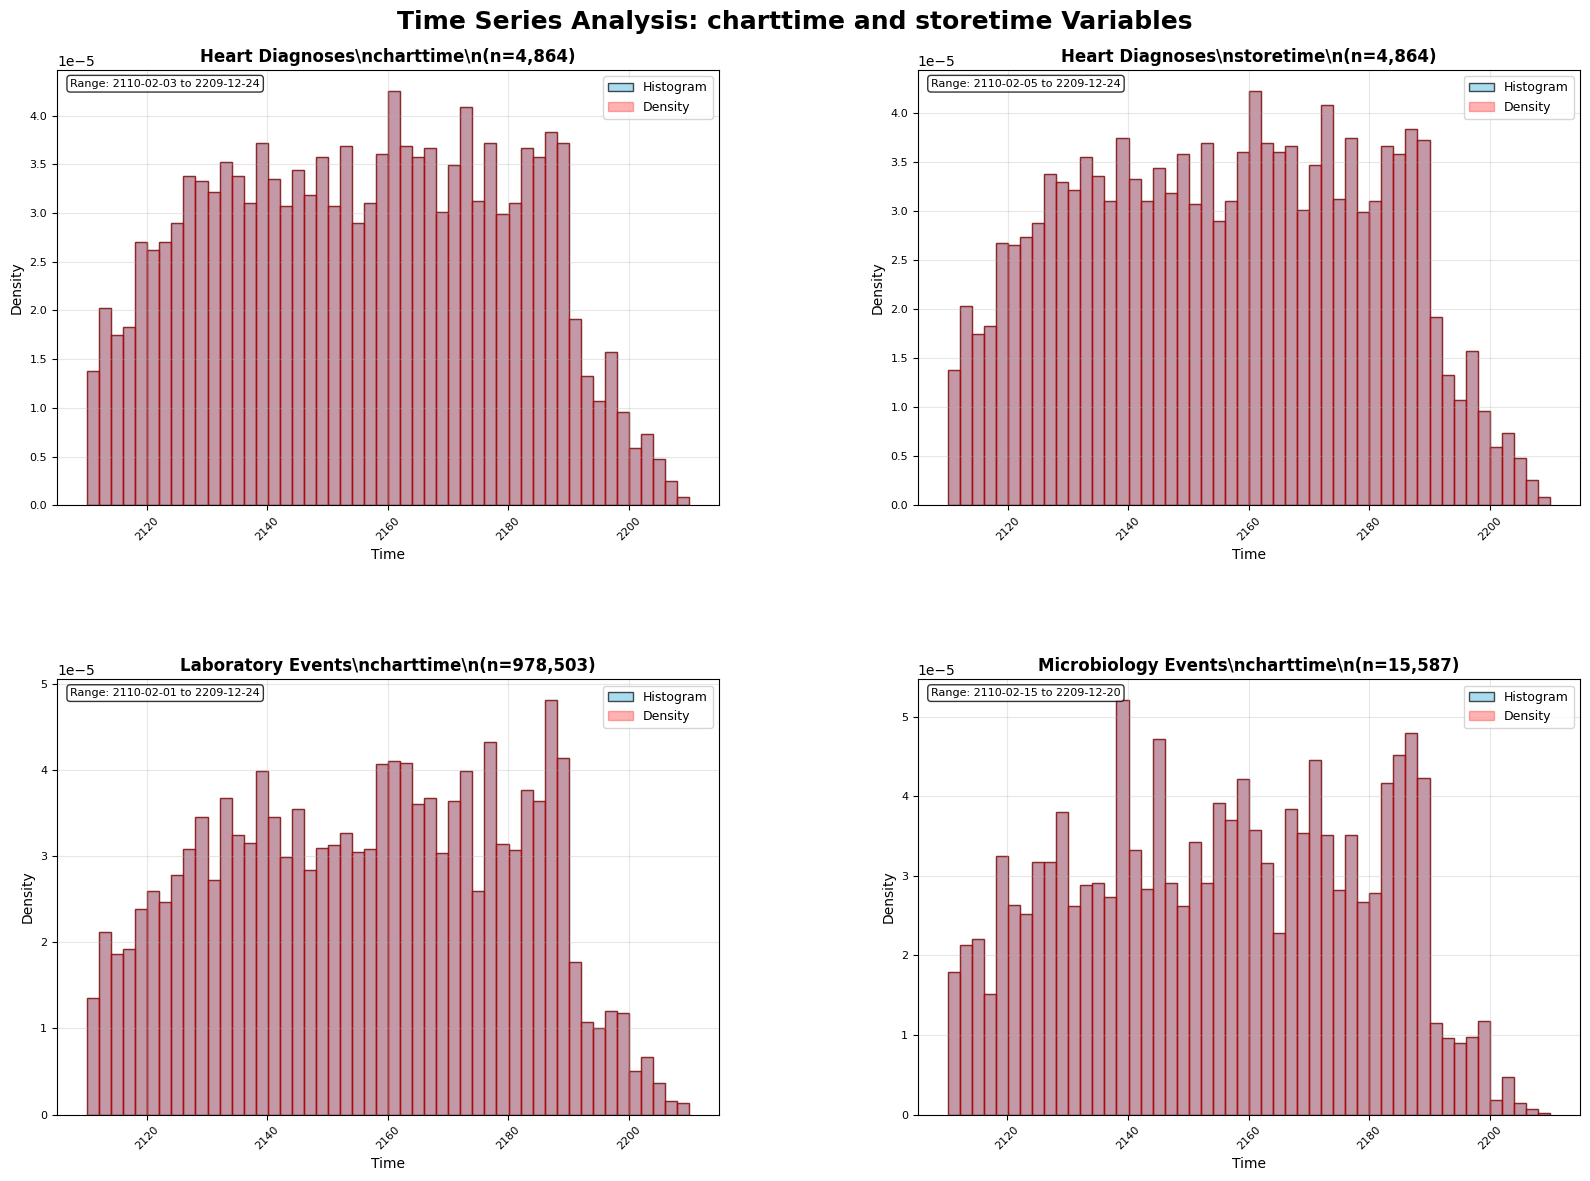


Detailed Time Statistics:

Heart Diagnoses:
  charttime:
    • Valid timestamps: 4,864
    • Date range: 2110-02-03 03:00:00 to 2209-12-24 03:00:00
    • Duration: 36483 days 00:00:00
    • Missing values: 0 (0.0%)
  storetime:
    • Valid timestamps: 4,864
    • Date range: 2110-02-05 20:09:00 to 2209-12-24 14:01:00
    • Duration: 36480 days 17:52:00
    • Missing values: 0 (0.0%)

Laboratory Events:
  charttime:
    • Valid timestamps: 978,503
    • Date range: 2110-02-01 09:40:00 to 2209-12-24 09:00:00
    • Duration: 36484 days 23:20:00
    • Missing values: 0 (0.0%)

Microbiology Events:
  charttime:
    • Valid timestamps: 15,587
    • Date range: 2110-02-15 01:37:00 to 2209-12-20 17:42:00
    • Duration: 36467 days 16:05:00
    • Missing values: 0 (0.0%)

Time series analysis complete!


In [15]:
# Time series analysis: charttime and storetime variables
print("Creating time series analysis for charttime and storetime...")
print("="*80)

# Find all datasets with time columns
time_datasets = {}
for dataset_name, df in dfs.items():
    time_cols = []
    for col in df.columns:
        if 'charttime' in col.lower() or 'storetime' in col.lower():
            time_cols.append(col)
    if time_cols:
        time_datasets[dataset_name] = time_cols
        print(f"{dataset_name}: {time_cols}")

print(f"\nFound time columns in {len(time_datasets)} datasets")

# Create comprehensive time series plots
def plot_time_series_analysis(datasets_with_time):
    """Create histogram and density plots for time variables"""
    
    # Calculate subplot layout
    total_plots = sum(len(cols) for cols in datasets_with_time.values())
    n_cols = 2  # Two plots per row
    n_rows = (total_plots + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6))
    fig.suptitle('Time Series Analysis: charttime and storetime Variables', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Ensure axes is 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    if n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    plot_idx = 0
    
    for dataset_name, time_cols in datasets_with_time.items():
        print(f"\nProcessing {dataset_name}...")
        
        for col in time_cols:
            if plot_idx >= total_plots:
                break
                
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            ax = axes[row, col_idx]
            
            # Get data and convert to datetime
            df = dfs[dataset_name]
            time_data = pd.to_datetime(df[col], errors='coerce').dropna()
            
            if len(time_data) > 0:
                print(f"  {col}: {len(time_data):,} valid timestamps")
                
                # Create histogram
                ax.hist(time_data, bins=50, alpha=0.7, density=True, 
                       color='skyblue', edgecolor='black', label='Histogram')
                
                # Create density plot overlay
                try:
                    # Convert to numeric for density calculation
                    time_numeric = time_data.astype('int64') / 1e9  # Convert to seconds
                    from scipy import stats
                    density = stats.gaussian_kde(time_numeric)
                    x_range = np.linspace(time_numeric.min(), time_numeric.max(), 100)
                    x_datetime = pd.to_datetime(x_range * 1e9)
                    ax.plot(x_datetime, density(time_range), 'r-', linewidth=2, 
                           alpha=0.8, label='Density')
                except:
                    # Fallback: simple density estimation
                    ax.hist(time_data, bins=50, alpha=0.3, density=True, 
                           color='red', edgecolor='red', label='Density')
                
                # Customize plot
                ax.set_title(f'{dataset_name}\\n{col}\\n(n={len(time_data):,})', 
                           fontsize=12, fontweight='bold')
                ax.set_xlabel('Time', fontsize=10)
                ax.set_ylabel('Density', fontsize=10)
                ax.legend(fontsize=9)
                ax.grid(True, alpha=0.3)
                
                # Rotate x-axis labels for better readability
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                ax.tick_params(axis='y', labelsize=8)
                
                # Add statistics
                time_stats = f'Range: {time_data.min().strftime("%Y-%m-%d")} to {time_data.max().strftime("%Y-%m-%d")}'
                ax.text(0.02, 0.98, time_stats, transform=ax.transAxes, 
                       verticalalignment='top', fontsize=8,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
            else:
                ax.text(0.5, 0.5, f'No valid timestamps\\nin {col}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{dataset_name}\\n{col} (No Data)', fontsize=12)
            
            plot_idx += 1
    
    # Hide empty subplots
    for i in range(plot_idx, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.3)
    
    # Save the plot
    try:
        filepath = out_dir / "time_series_analysis.jpg"
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"\nSaved: time_series_analysis.jpg")
    except Exception as e:
        print(f"\nCould not save plot: {e}")
    
    plt.show()

# Create the time series analysis
if time_datasets:
    plot_time_series_analysis(time_datasets)
    
    # Print detailed time statistics
    print(f"\nDetailed Time Statistics:")
    print("="*80)
    for dataset_name, time_cols in time_datasets.items():
        print(f"\n{dataset_name}:")
        for col in time_cols:
            df = dfs[dataset_name]
            time_data = pd.to_datetime(df[col], errors='coerce').dropna()
            if len(time_data) > 0:
                print(f"  {col}:")
                print(f"    • Valid timestamps: {len(time_data):,}")
                print(f"    • Date range: {time_data.min()} to {time_data.max()}")
                print(f"    • Duration: {time_data.max() - time_data.min()}")
                print(f"    • Missing values: {df[col].isnull().sum():,} ({df[col].isnull().sum()/len(df)*100:.1f}%)")
else:
    print("No time columns found in any dataset")

print(f"\nTime series analysis complete!")


In [9]:
# Load the third CSV file (microbiology_events_codes_3.csv)
third_csv = "microbiology_events_codes_3.csv"
df3 = pd.read_csv(os.path.join(data_path, third_csv))

# Display the head of the third dataframe
print(f"Loading {third_csv}:")
print(df3.head())


Loading microbiology_events_codes_3.csv:
   subject_id     hadm_id            chartdate            charttime  \
0    10000980  26913865.0  2189-06-27 00:00:00  2189-06-27 10:52:00   
1    10002155  23822395.0  2129-08-04 00:00:00  2129-08-04 17:04:00   
2    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 15:54:00   
3    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   
4    10002155  23822395.0  2129-08-05 00:00:00  2129-08-05 18:43:00   

  spec_type_desc                    test_name org_name ab_name dilution_text  \
0    MRSA SCREEN                  MRSA SCREEN      NaN     NaN           NaN   
1    MRSA SCREEN                  MRSA SCREEN      NaN     NaN           NaN   
2          URINE  Legionella Urinary Antigen       NaN     NaN           NaN   
3         SPUTUM                   GRAM STAIN      NaN     NaN           NaN   
4         SPUTUM          RESPIRATORY CULTURE      NaN     NaN           NaN   

  dilution_comparison  dilution_value interpretatio

## 6. Correlation Analysis

In this section, we'll create a correlation matrix between key variables from different datasets:
- **dilution_value** (Microbiology Events)
- **age** (Heart Diagnoses)
- **ref_range_upper** and **ref_range_lower** (Laboratory Events)
- **valuenum** (Laboratory Events)
- **seq_num** (Procedure Codes)


In [10]:
# Prepare data for correlation analysis
print("Merging datasets for correlation analysis...")
print("="*60)

# First, check which columns are available
print("\nChecking columns...")
print(f"df1 has subject_id: {'subject_id' in df1.columns}")
print(f"df2 has subject_id: {'subject_id' in df2.columns}")
print(f"df2 columns: {df2.columns.tolist()[:10]}")  # First 10 columns

# Start with df1 (Heart Diagnoses) - select relevant columns
df1_subset = df1[['subject_id', 'hadm_id', 'age']].copy()
df1_subset['age'] = pd.to_numeric(df1_subset['age'], errors='coerce')

# df2 (Laboratory Events) - select relevant columns
# Check if subject_id exists, otherwise use only hadm_id
df2_cols = ['hadm_id', 'valuenum', 'ref_range_lower', 'ref_range_upper']
if 'subject_id' in df2.columns:
    df2_cols = ['subject_id'] + df2_cols
    
df2_subset = df2[df2_cols].copy()
df2_subset['valuenum'] = pd.to_numeric(df2_subset['valuenum'], errors='coerce')
df2_subset['ref_range_lower'] = pd.to_numeric(df2_subset['ref_range_lower'], errors='coerce')
df2_subset['ref_range_upper'] = pd.to_numeric(df2_subset['ref_range_upper'], errors='coerce')

# Aggregate df2 by patient (since there are many lab events per patient)
# We'll take the mean of numeric values
group_cols_df2 = ['hadm_id'] if 'subject_id' not in df2_cols else ['subject_id', 'hadm_id']
df2_agg = df2_subset.groupby(group_cols_df2).agg({
    'valuenum': 'mean',
    'ref_range_lower': 'mean',
    'ref_range_upper': 'mean'
}).reset_index()

# df3 (Microbiology Events) - select relevant columns
df3_subset = df3[['subject_id', 'hadm_id', 'dilution_value']].copy()
df3_subset['dilution_value'] = pd.to_numeric(df3_subset['dilution_value'], errors='coerce')

# Aggregate df3 by patient
df3_agg = df3_subset.groupby(['subject_id', 'hadm_id']).agg({
    'dilution_value': 'mean'
}).reset_index()

# df4 (Procedure Codes) - select relevant columns  
df4_subset = df4[['subject_id', 'hadm_id', 'seq_num']].copy()
df4_subset['seq_num'] = pd.to_numeric(df4_subset['seq_num'], errors='coerce')

# Aggregate df4 by patient
df4_agg = df4_subset.groupby(['subject_id', 'hadm_id']).agg({
    'seq_num': 'mean'
}).reset_index()

# Merge all dataframes
print("\nMerging dataframes...")
# Determine merge keys based on what's available in df2
merge_on = ['hadm_id'] if 'subject_id' not in df2_cols else ['subject_id', 'hadm_id']
print(f"Merging on: {merge_on}")

correlation_df = df1_subset.merge(df2_agg, on=merge_on, how='outer')
correlation_df = correlation_df.merge(df3_agg, on=['subject_id', 'hadm_id'], how='outer')
correlation_df = correlation_df.merge(df4_agg, on=['subject_id', 'hadm_id'], how='outer')

# Select only the variables for correlation
correlation_vars = ['age', 'valuenum', 'ref_range_lower', 'ref_range_upper', 
                    'dilution_value', 'seq_num']
correlation_data = correlation_df[correlation_vars]

print(f"\nMerged dataset shape: {correlation_df.shape}")
print(f"Variables for correlation: {correlation_vars}")
print(f"\nData summary:")
print(correlation_data.describe())
print(f"\nMissing values:")
print(correlation_data.isnull().sum())


Merging datasets for correlation analysis...

Checking columns...
df1 has subject_id: True
df2 has subject_id: False
df2 columns: ['hadm_id', 'charttime', 'value', 'valuenum', 'valueuom', 'ref_range_lower', 'ref_range_upper', 'flag', 'label', 'fluid']

Merging dataframes...
Merging on: ['hadm_id']

Merged dataset shape: (5166, 8)
Variables for correlation: ['age', 'valuenum', 'ref_range_lower', 'ref_range_upper', 'dilution_value', 'seq_num']

Data summary:
               age     valuenum  ref_range_lower  ref_range_upper  \
count  1363.000000  4855.000000      4855.000000      4855.000000   
mean     68.978723    61.696782        31.704593        59.095321   
std      14.973358   125.421164         3.423356        75.737748   
min      18.000000     1.400000         0.500000         2.000000   
25%      60.000000    42.489736        29.959386        50.990805   
50%      70.000000    47.492578        31.670227        54.557104   
75%      81.000000    56.378742        33.369252        

Creating correlation heatmap...



Correlation Matrix:
                   age  valuenum  ref_range_lower  ref_range_upper  \
age              1.000    -0.038            0.052           -0.100   
valuenum        -0.038     1.000           -0.009            0.007   
ref_range_lower  0.052    -0.009            1.000            0.058   
ref_range_upper -0.100     0.007            0.058            1.000   
dilution_value   0.111    -0.029           -0.002           -0.015   
seq_num         -0.015    -0.005            0.055            0.008   

                 dilution_value  seq_num  
age                       0.111   -0.015  
valuenum                 -0.029   -0.005  
ref_range_lower          -0.002    0.055  
ref_range_upper          -0.015    0.008  
dilution_value            1.000   -0.149  
seq_num                  -0.149    1.000  

Saved: correlation_matrix_heatmap.jpg


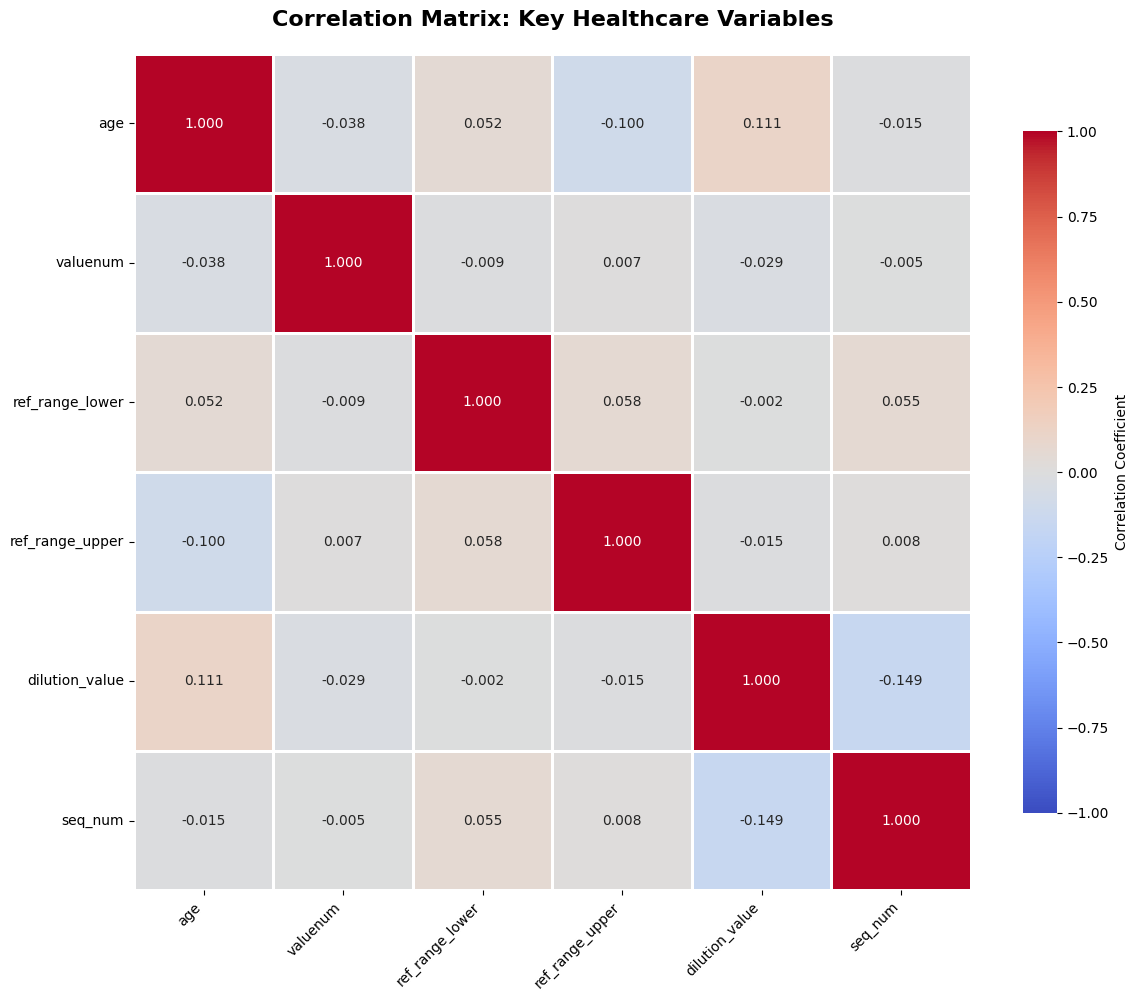


Correlation Insights:

Strongest correlations:
  • dilution_value ↔ seq_num: -0.149 (Weak negative)
  • age ↔ dilution_value: 0.111 (Weak positive)
  • age ↔ ref_range_upper: -0.100 (Weak negative)
  • ref_range_lower ↔ ref_range_upper: 0.058 (Weak positive)
  • ref_range_lower ↔ seq_num: 0.055 (Weak positive)

Correlation analysis complete!


In [ ]:
# Compute correlation matrix and create heatmap
print("Creating correlation heatmap...")
print("="*60)

# Calculate correlation matrix (pairwise deletion of missing values)
correlation_matrix = correlation_data.corr(method='pearson')

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Create a beautiful heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap with annotations
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            fmt='.3f',   # Format to 3 decimal places
            cmap='coolwarm',  # Color scheme (blue=negative, red=positive)
            center=0,    # Center colormap at 0
            square=True,  # Make cells square
            linewidths=1,  # Add gridlines
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1,  # Set color scale limits
            ax=ax)

# Customize the plot
ax.set_title('Correlation Matrix: Key Healthcare Variables', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('')

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout
plt.tight_layout()

# Save the plot
try:
    filepath = out_dir / "correlation_matrix_heatmap.jpg"
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"\nSaved: correlation_matrix_heatmap.jpg")
except Exception as e:
    print(f"\nCould not save plot: {e}")

plt.show()

# Additional insights
print("\nCorrelation Insights:")
print("="*60)

# Find strongest correlations (excluding diagonal)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        var1 = correlation_matrix.columns[i]
        var2 = correlation_matrix.columns[j]
        corr_val = correlation_matrix.iloc[i, j]
        if not pd.isna(corr_val):
            corr_pairs.append((var1, var2, corr_val))

# Sort by absolute correlation value
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print("\nStrongest correlations:")
for var1, var2, corr in corr_pairs_sorted[:5]:
    strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
    direction = "positive" if corr > 0 else "negative"
    print(f"  • {var1} ↔ {var2}: {corr:.3f} ({strength} {direction})")
